In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
root_dir = Path.cwd().parents[1]
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))
print(root_dir)

/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme


In [2]:
import pprint

import numpy as np
from matplotlib import pyplot as plt
from inference.BayesModel import BayesModel
from inference.HierarchicalBayesModel import prior_structure, norm_ppf, halfnorm_ppf
from inference.network import Network
from empirical.create_surrogate_data import SurrogateData
from inference.NestedSamplingMethods import run_sampling, plot_results


# Generate data
* create 2 population network (inhib/exc) without mixed synapses
* ensure constant structure parameters ($\varepsilon$, $\eta$, $\tau_{1,2}$) while others may ($\alpha_{0_{1,2}}$) or should ($\bar{\nu}_{1,2}$) vary
* drive with different input currents (balance equation -> nu_bar), assume constant drive to all

In [3]:
def create_data_from_params(ground_truth_params,N=1000,T=1200,plot=False):
    net = Network(**{key: ground_truth_params[key] for key in ["eps", "eta"]})
    for p,pop in enumerate(ground_truth_params["distr"]):
        net.register_population(p,**{key: pop[key] for key in ["nu_bar", "alpha_0", "J0"]})

        for s,syn in enumerate(pop["synapses"]):
            net.populations[p].register_synapse(s, **{key: syn[key] for key in ["tau_I"]})

    net.solve_selfcon()

    ref_values = {
        "distr": net.export_distr(),
        # "distr": [
        #     distr_params(gamma=2.1, delta=4., nu_max=25.0,kappa=4.),
        #     distr_params(gamma=1.5, delta=4.5, nu_max=25.0,kappa=1.),
        #     # distr_params(gamma=1.9, delta=3.5, nu_max=25.0,kappa=1.),
        # ],
        "join": False,
        "N": N,
        "T": T,
    }

    SD = SurrogateData(N=ref_values["N"],T=ref_values["T"],n_animals=1)
    SD.artificial_data(ref_values,plot=False)
    if plot:
        SD.plot_rates()

    return SD, net

In [4]:
def define_biological_prior(n_conditions):
    def bounded_flat(x,low,high):
        return x*(high-low)+low

    prior = {}
    prior["eps"] = prior_structure(bounded_flat, low=0.0, high=np.sqrt(1./2), label="$\\epsilon$")
    prior["eta"] = prior_structure(bounded_flat, low=0.0, high=1.0, label="$\\eta$")

    for p in range(2):
        prior[f"nu_bar_pop{p}"] = prior_structure(
            halfnorm_ppf, loc=0.0, scale=5.0,
            # norm_ppf,
            # mean=prior_structure(halfnorm_ppf, loc=0.0, scale=5.0),
            # sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=1.),
            # shape=(n_conditions,) if p==1 else (1,),
            shape=(n_conditions,),
            label="$\\bar{\\nu}_"+str(p)+"$"
        )

        prior[f"alpha_0_pop{p}"] = prior_structure(
            halfnorm_ppf,loc=0.0,scale=0.05,label="$\\alpha_0$"
        )

        prior[f"tau_I_s0_pop{p}"] = prior_structure(
            # None,value=[0.03 if p==0 else 0.005],
            halfnorm_ppf,loc=0.0,scale=0.02,
            label="$\\tau_{I_"+str(p)+"}$"
        )
    return prior

In [5]:
def prepare_model(event_counts,prior, T=120., biological=False):
    BM = BayesModel()  # logLevel=logging.WARNING)
    BM.prepare_data(event_counts, T=T)
    BM.set_priors(prior)
    prior_transformation = BM.set_prior_transform(vectorized=False)
    loglikelihood = BM.set_logl(
        vectorized=False,
        correct_N=0,
        bias_to_expected_max=0,
        bias_to_mean=0,
        biological=biological,
    )
    return prior_transformation, loglikelihood, BM

In [6]:
def build_truths(ground_truth_params, conditions=None):
    truths = {}
    for key in ["eps","eta"]:
        truths[key] = ground_truth_params[key]
    for p,pop in enumerate(ground_truth_params["distr"]):
        for key in ["nu_bar","alpha_0"]:
            truths[f"{key}_pop{p}"] = pop[key]

        for s,syn in enumerate(pop["synapses"]):
            for key in ["tau_I"]:
                truths[f"{key}_s{s}_pop{p}"] = syn[key]
    if conditions:
        for key, val in conditions.items():
            truths[key] = val  # for all conditions
    return truths


In [7]:
ground_truth_params = {
    "eps": 0.6,
    "eta": 0.4,
    "distr": [
        {
            "nu_bar": 2., 
            "alpha_0": 0.02, 
            "J0": -1.,
            "synapses": [
                {"tau_I": 0.03}
            ],
        },
        {
            "nu_bar": 1., 
            "alpha_0": 0.04, 
            "J0": 1.,
            "synapses": [
                {"tau_I": 0.005}
            ],
        },
    ],
}

import copy
def run_with_conditions(ground_truth_params,conditions,n_live=100):

    gtp = copy.deepcopy(ground_truth_params)
    truths = build_truths(gtp, conditions={"nu_bar_pop1": conditions})

    n_c = len(conditions)

    N = 1000; T = 120
    event_counts = np.zeros((n_c,2,N))
    for i, nu in enumerate(conditions):
        gtp["distr"][1]["nu_bar"] = nu
        SD,net = create_data_from_params(gtp,N=N,T=T,plot=True)
        event_counts[i,...] = SD.event_counts
    
    prior = define_biological_prior(event_counts.shape[0])
    prior_transformation, loglikelihood, BM = prepare_model(event_counts, prior, T, biological=True)
    results, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12,n_live=n_live)
    
    plot_results(BM,results, mode="dynesty",truths=truths)
    return SD, BM, results, sampler


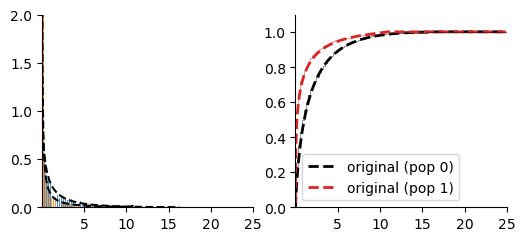

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


2681it [00:23, 114.22it/s, +100 | bound: 63 | nc: 1 | ncall: 160967 | eff(%):  1.729 | loglstar:   -inf < -1935.647 <    inf | logz: -1962.491 +/-  0.552 | dlogz:  0.012 >  1.000]


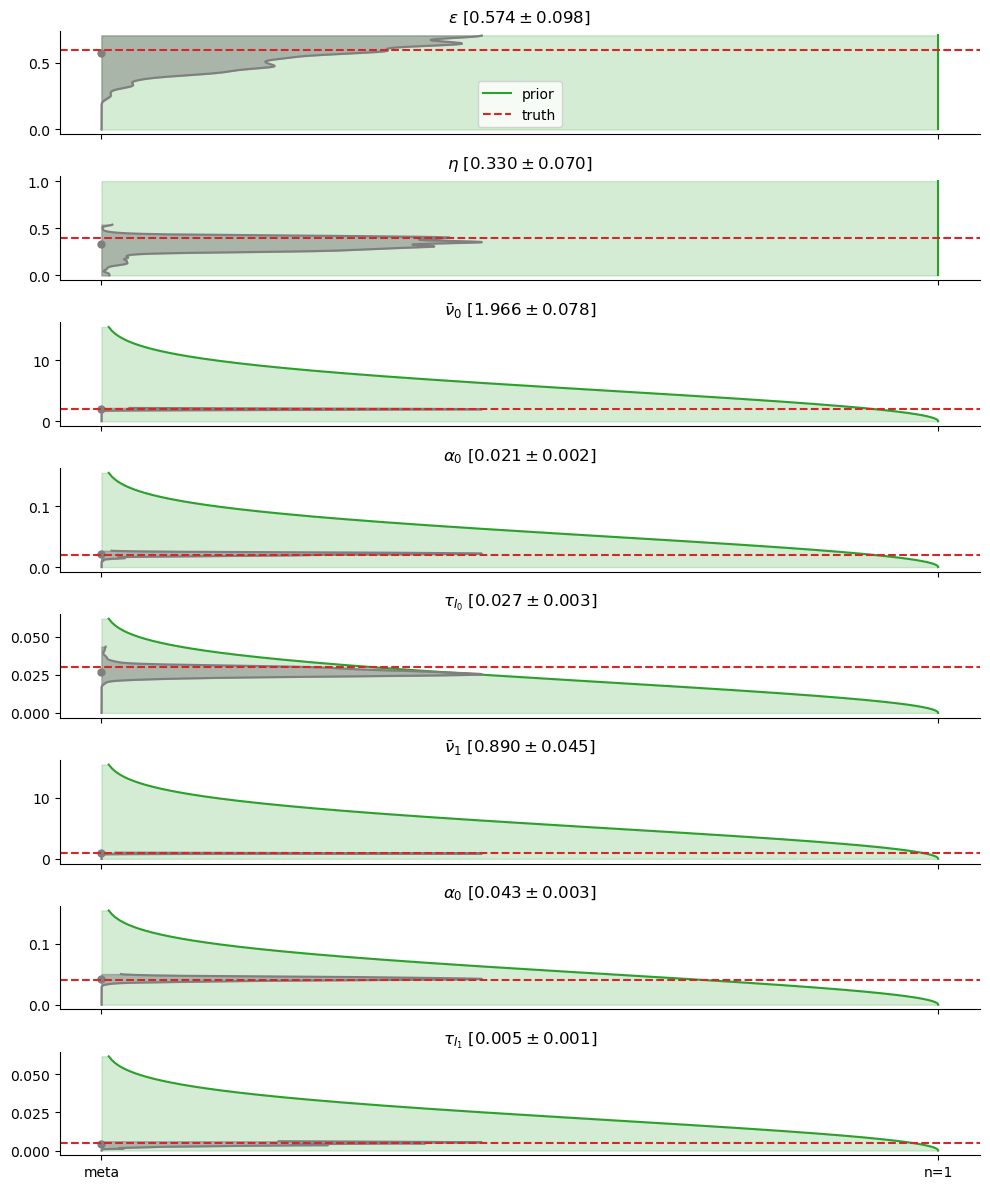

In [17]:
SD,BM,results,sampler = run_with_conditions(ground_truth_params, [1.],n_live=100)

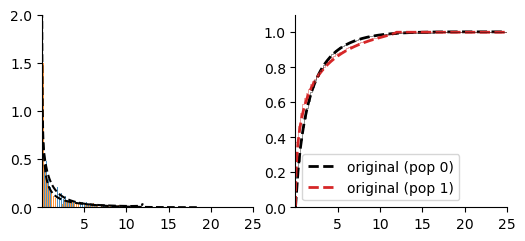

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


2681it [00:22, 117.01it/s, +100 | bound: 63 | nc: 1 | ncall: 158072 | eff(%):  1.760 | loglstar:   -inf < -2223.658 <    inf | logz: -2250.493 +/-  0.551 | dlogz:  0.011 >  1.000]


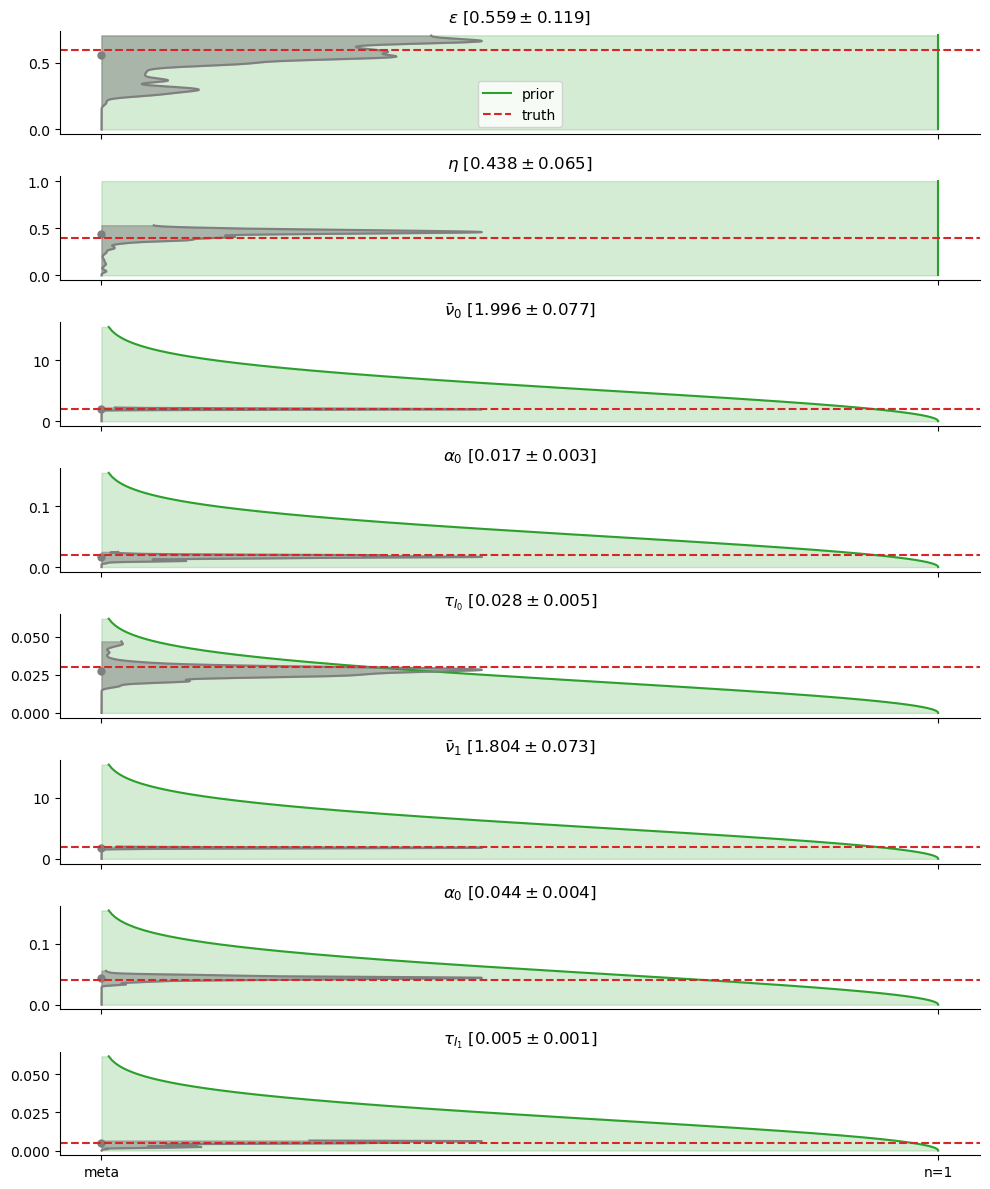

In [18]:
SD,BM,results,sampler = run_with_conditions(ground_truth_params, [2.],n_live=100)

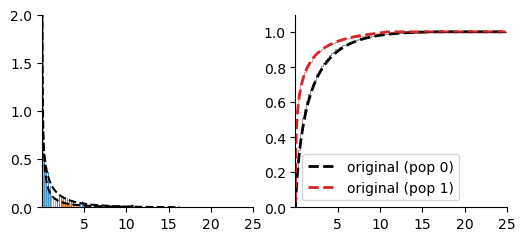

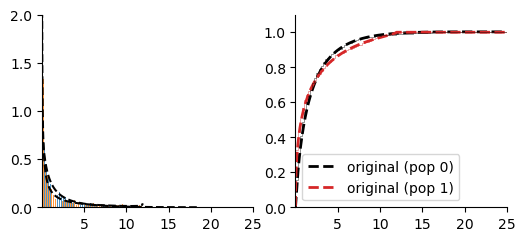

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


4009it [01:15, 53.44it/s, +100 | bound: 98 | nc: 1 | ncall: 288774 | eff(%):  1.423 | loglstar:   -inf < -4162.069 <    inf | logz: -4202.209 +/-  0.663 | dlogz:  0.013 >  1.000]


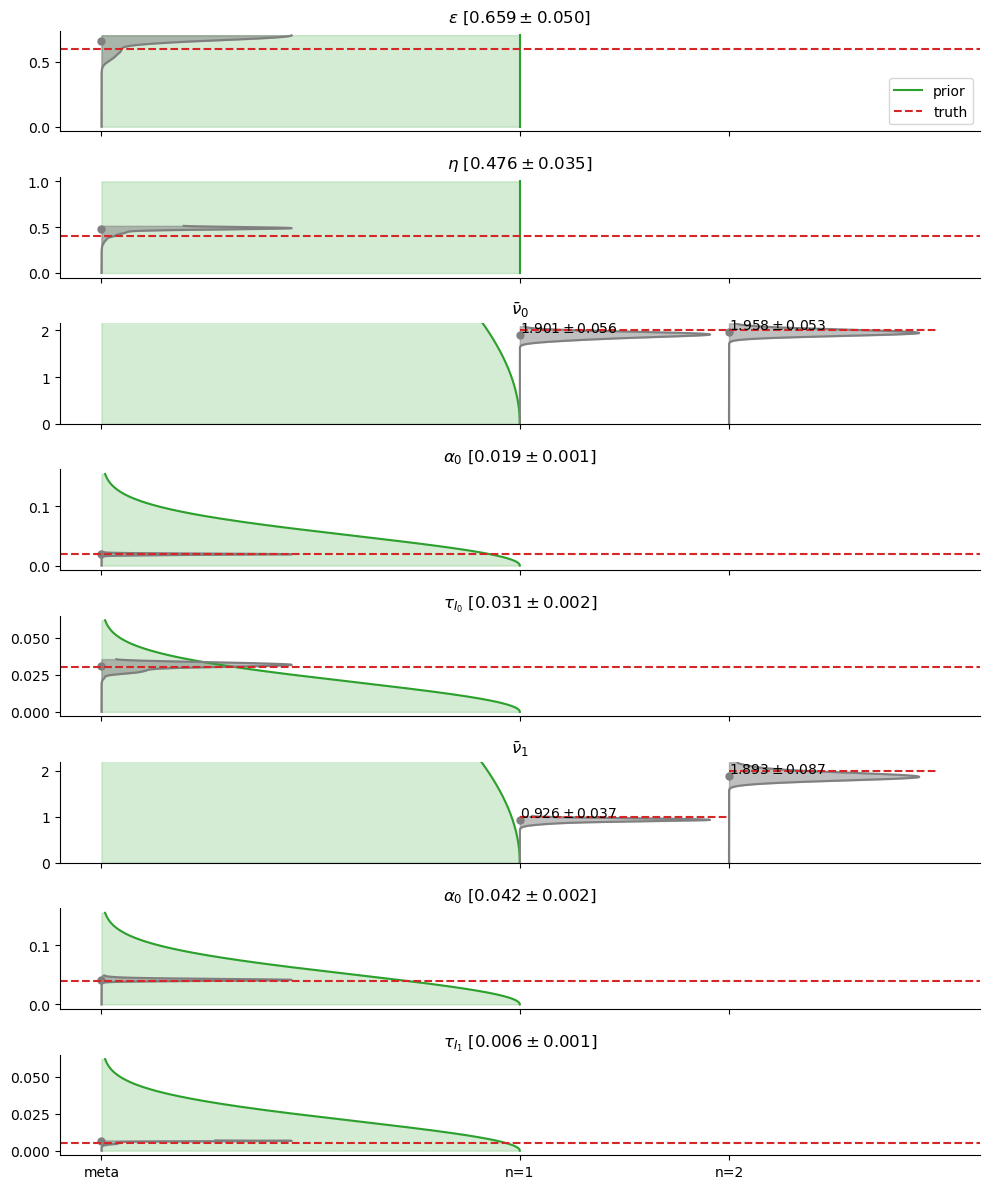

In [19]:
SD,BM,results,sampler = run_with_conditions(ground_truth_params, [1.,2.],n_live=100)

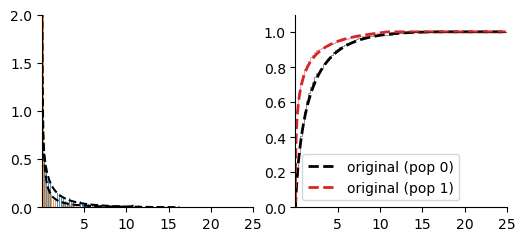

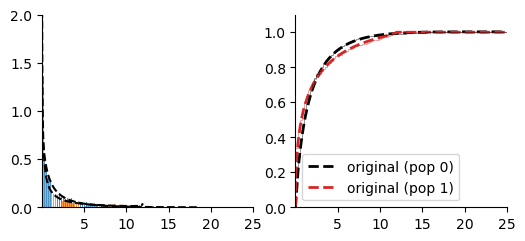

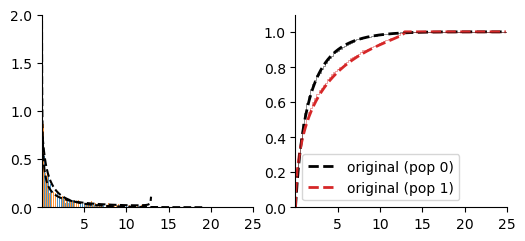

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


4636it [02:24, 32.13it/s, +100 | bound: 113 | nc: 1 | ncall: 386471 | eff(%):  1.226 | loglstar:   -inf < -6608.642 <    inf | logz: -6654.985 +/-  0.713 | dlogz:  0.012 >  1.000]


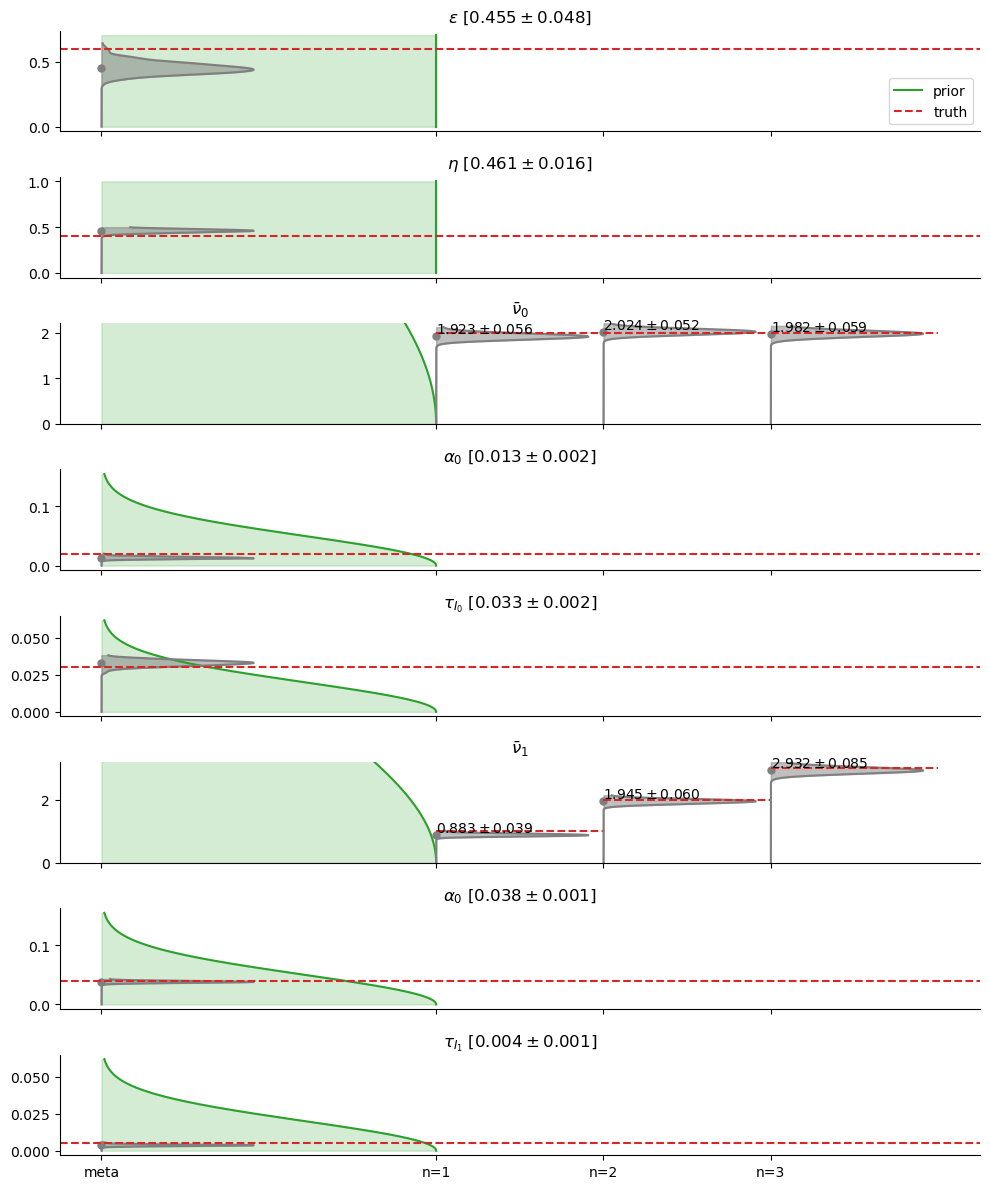

In [20]:
SD,BM,results,sampler = run_with_conditions(ground_truth_params, [1.,2.,3.],n_live=100)

# Compare separate vs joint inference

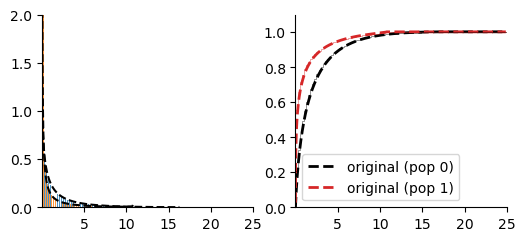

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


12399it [01:40, 123.97it/s, +400 | bound: 78 | nc: 1 | ncall: 725297 | eff(%):  1.766 | loglstar:   -inf < -5034.937 <    inf | logz: -5066.155 +/-  0.303 | dlogz:  0.003 >  1.000]


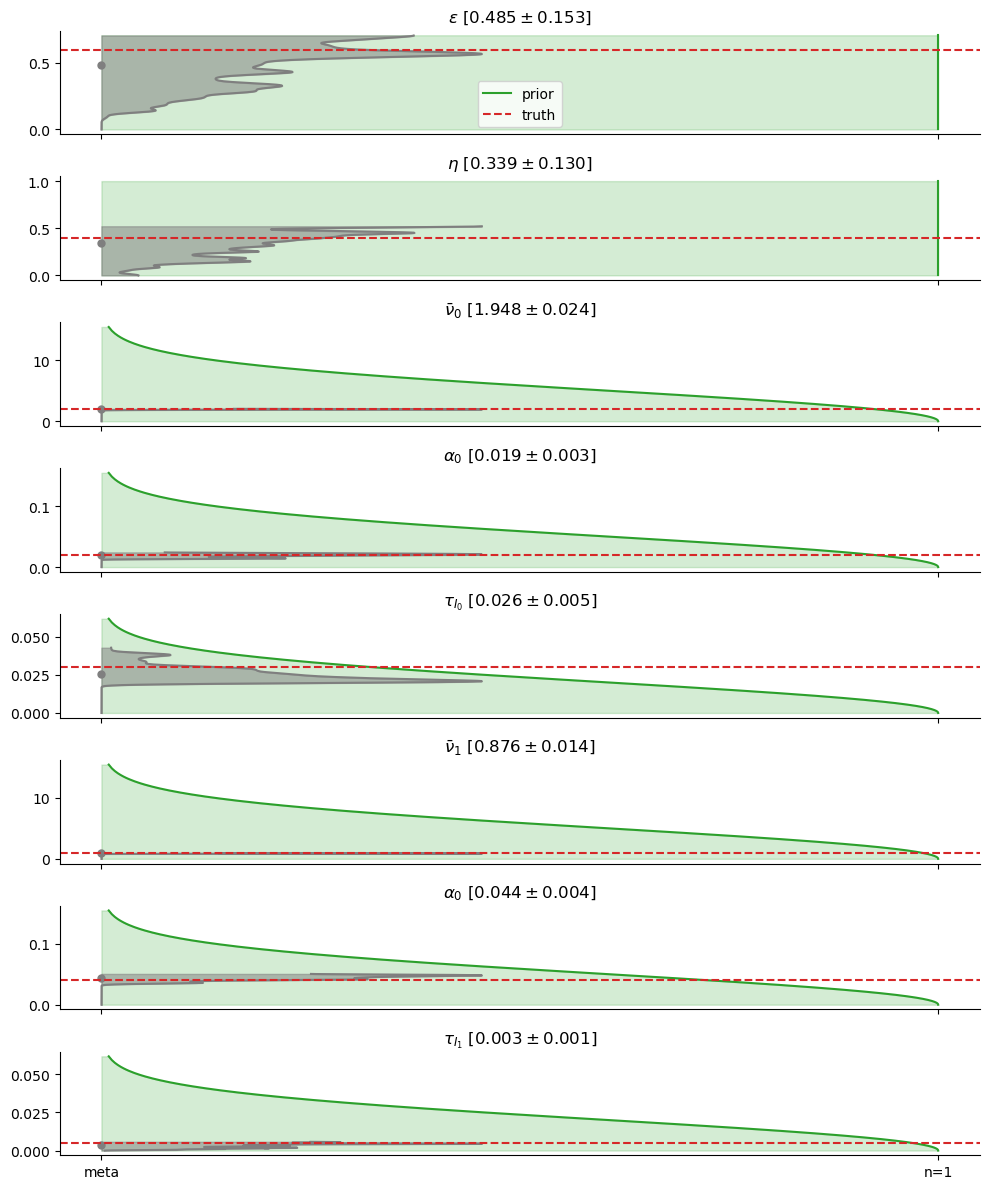

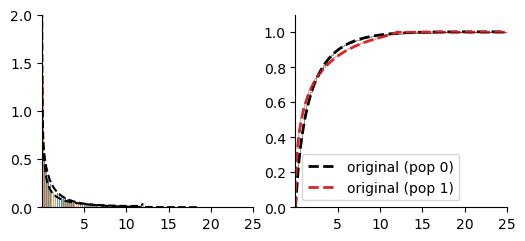

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


13067it [01:49, 118.93it/s, +400 | bound: 83 | nc: 1 | ncall: 774708 | eff(%):  1.739 | loglstar:   -inf < -5734.410 <    inf | logz: -5767.267 +/-  0.313 | dlogz:  0.003 >  1.000]


Different values of kappa currently not possible - check what needs to be done!
running nested sampling


20169it [06:03, 55.46it/s, +400 | bound: 131 | nc: 1 | ncall: 1418060 | eff(%):  1.451 | loglstar:   -inf < -10774.358 <    inf | logz: -10825.004 +/-  0.395 | dlogz:  0.003 >  1.000]


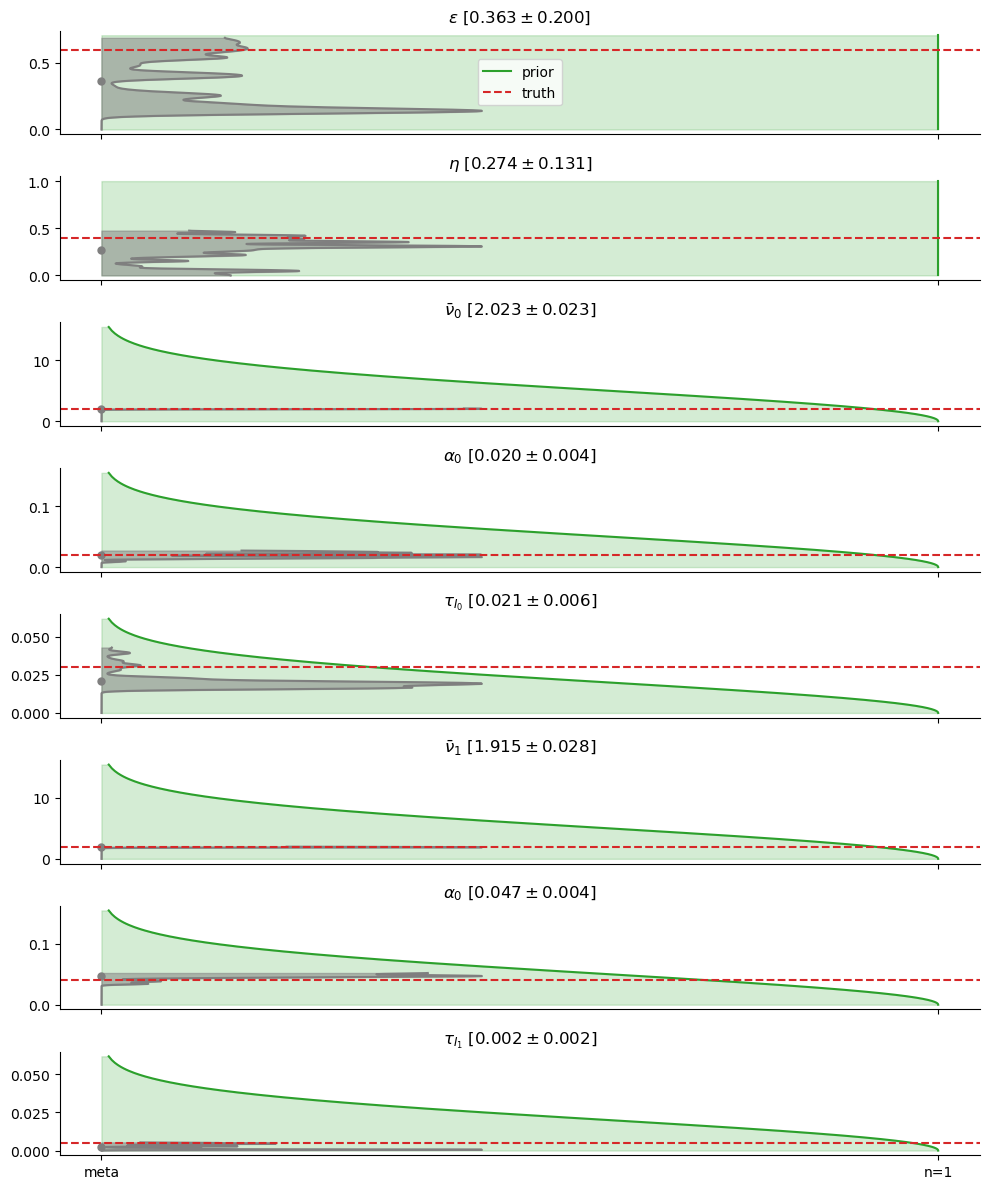

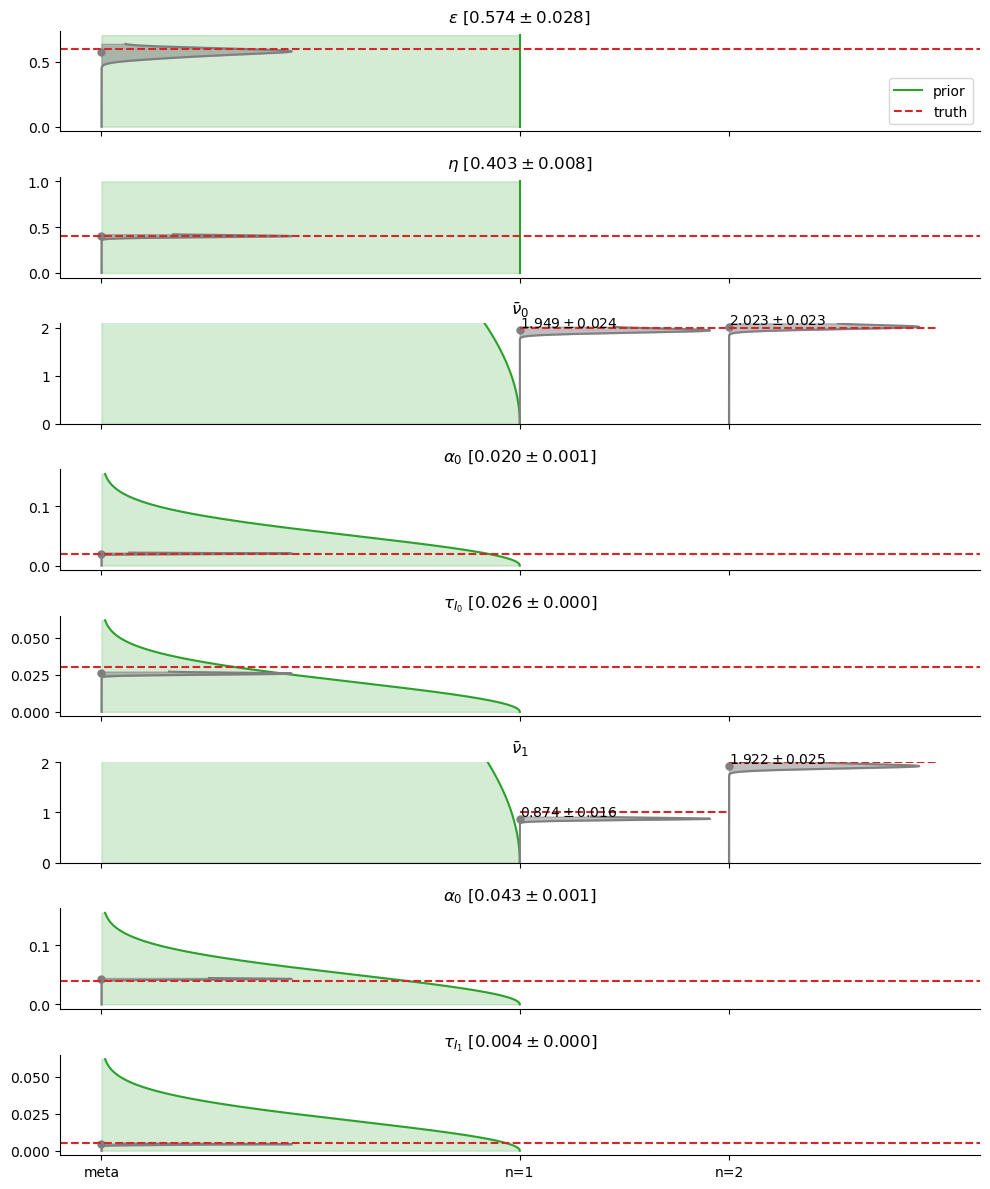

In [59]:
ground_truth_params = {
    "eps": 0.6,
    "eta": 0.4,
    "distr": [
        {
            "nu_bar": 2., 
            "alpha_0": 0.02, 
            "J0": -1.,
            "synapses": [
                {"tau_I": 0.03}
            ],
        },
        {
            "nu_bar": 1., 
            "alpha_0": 0.04, 
            "J0": 1.,
            "synapses": [
                {"tau_I": 0.005}
            ],
        },
    ],
}
gtp = copy.deepcopy(ground_truth_params)

conditions = [1.,2.]


n_c = len(conditions)

n_live = 400
N = 10000; T = 120
event_counts = np.zeros((n_c,2,N))
results = []
names = []
for i, nu in enumerate(conditions):
    gtp["distr"][1]["nu_bar"] = nu
    SD,net = create_data_from_params(gtp,N=N,T=T,plot=True)
    event_counts[i,...] = SD.event_counts

    prior = define_biological_prior(1)
    prior_transformation, loglikelihood, BM = prepare_model(event_counts[i,np.newaxis,...], prior, T, biological=True)
    res, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12,n_live=n_live)
    truths = build_truths(gtp)
    plot_results(BM,res, mode="dynesty",truths=truths)
    results.append(res)
    names.append(BM.parameter_names_all)

prior = define_biological_prior(event_counts.shape[0])
prior_transformation, loglikelihood, BM = prepare_model(event_counts, prior, T, biological=True)
res, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12,n_live=n_live)
truths = build_truths(gtp, conditions={"nu_bar_pop1": conditions})
plot_results(BM,res, mode="dynesty",truths=truths)
results.append(res)
names.append(BM.parameter_names_all)

# return SD, BM, results, sampler

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ---- Optional helpers for printing nicely ----
def top_features_for_pc(contrib, feature_names=None, pc=0, k=5):
    idx = np.argsort(contrib[:, pc])[::-1][:k]
    if feature_names is None:
        feature_names = [f"f{i}" for i in range(contrib.shape[0])]
    return [(feature_names[i], contrib[i, pc]) for i in idx]

In [61]:
def update_key(net,key,val,ranges=None):
    if ranges is None:
        ranges = [-1, -1, -1]
    if key in ["eps", "eta"]:
        setattr(net,key, val)
    elif key in ["nu_bar","alpha_0"]:

        iter_populations = range(net.n_pop) if ranges[1] == -1 else [ranges[1]]

        for p in iter_populations:
            setattr(net.populations[p],key, val)
    else:
        iter_populations = range(net.n_pop) if ranges[1] == -1 else [ranges[1]]
        for p in iter_populations:
            iter_synapses = range(len(net.populations[p].synapses)) if ranges[2] == -1 else [ranges[2]]
            for s in iter_synapses:
                setattr(net.populations[p].synapses[s],key, val)

In [62]:
from scipy.optimize import fsolve
net_mf = copy.deepcopy(net)

def meta_parameter_distance(x,net,net_mf,eps,eta,param_names,param_ranges):

    assert len(x) == len(param_names), "wrong x / param_names"
    assert len(x) == len(param_ranges), "wrong x / param_ranges"

    net_mf.eps = eps
    net_mf.eta = eta

    for val,key,range in zip(x,param_names,param_ranges):
        update_key(net_mf,key,val,range)
    net_mf.solve_selfcon()

    return [
        net.populations[0].gamma - net_mf.populations[0].gamma,
        net.populations[1].gamma - net_mf.populations[1].gamma,
        net.populations[0].delta - net_mf.populations[0].delta,
        net.populations[1].delta - net_mf.populations[1].delta,
        net.populations[0].nu_max - net_mf.populations[0].nu_max,
        net.populations[1].nu_max - net_mf.populations[1].nu_max
    ]

In [ ]:
param_names = ["nu_bar","alpha_0","tau_I","nu_bar","alpha_0","tau_I"]
param_ranges = [(0,0,0),(0,0,0),(0,0,0),(0,1,0),(0,1,0),(0,1,0)]
x0 = [2.,0.01,0.03,2.,0.02,0.01]
root = fsolve(meta_parameter_distance,x0,args = (net,net_mf,0.6,0.4,param_names,param_ranges),xtol=1e-10)
print(root)
print(meta_parameter_distance(root, 0.6, 0.4,param_names,param_ranges))

# net_mf.print_current_state()
for val,key,range in zip(root,param_names,param_ranges):
    update_key(net_mf,key,val,range)
net_mf.solve_selfcon()

net.populations[0].print_meta_parameter()
net_mf.populations[0].print_meta_parameter()

net.populations[1].print_meta_parameter()
net_mf.populations[1].print_meta_parameter()

TypeError: meta_parameter_distance() missing 2 required positional arguments: 'param_names' and 'param_ranges'

In [63]:
# net.populations[1].nu_bar = 1.

def find_manifold(net,n_steps=21):

    net_mf = copy.deepcopy(net)

    eta_array = np.linspace(0,1.,n_steps)
    eps_array = np.linspace(0,np.sqrt(1/2.),n_steps)

    param_names = ["nu_bar","alpha_0","tau_I","nu_bar","alpha_0","tau_I"]
    param_ranges = [(0,0,0),(0,0,0),(0,0,0),(0,1,0),(0,1,0),(0,1,0)]
    x0_ref = [1.,0.02,0.03,1.,0.02,0.005]
    x0 = copy.deepcopy(x0_ref)

    results = np.full((n_steps,n_steps,6), np.nan)
    dP = np.zeros((n_steps,n_steps))
    for i,eta in enumerate(eta_array):
        for j,eps in enumerate(eps_array):
            root = fsolve(meta_parameter_distance,x0,args = (net,net_mf,eps,eta,param_names,param_ranges),xtol=1e-10)

            dP_tmp = meta_parameter_distance(root, net, net_mf, eps, eta, param_names,param_ranges)
            dP[i,j] = np.sqrt(np.sum(np.array(dP_tmp)**2))
            if dP[i,j]<1e-6:
                results[i,j,:] = root
                x0 = root
            else:
                x0 = copy.deepcopy(x0_ref)
    return results, eps_array, eta_array

# results, eps_array, eta_array = find_manifold(net,n_steps=21)
# fig = plt.figure()
# ax = fig.add_subplot(121, projection='3d')
# X, Y = np.meshgrid(eta_array, eps_array)
# ax.plot_surface(X, Y, results[:,:,2])
# plt.setp(ax, zlim=(0,0.05))

# ax = fig.add_subplot(122, projection='3d')
# ax.plot_surface(X, Y, dP)
# plt.setp(ax, zlim=(-0.5,5))

In [64]:
manifolds = []
for i,c in enumerate(conditions):
    net.populations[1].nu_bar = conditions[i]
    mfs,eps_array,eta_array = find_manifold(net,n_steps=51)
    manifolds.append(mfs)

In [74]:
from plotly.subplots import make_subplots

import plotly.graph_objs as go

plot_3d = True

# fig = plt.figure(figsize=(8, 7))
# # ax = fig.add_subplot(1,3,i+1)
# if plot_3d:
#     ax = fig.add_subplot(1,1,1, projection='3d')
# else:
#     ax = fig.add_subplot(1,1,1)

colors = ['#d62728', '#1f77b4', '#2ca02c']  # Plotly equivalents for red, blue, green
scaler = StandardScaler()
for i,(res,names_) in enumerate(zip(results[::-1],names[::-1])):
    # for each dataset find dimensions wich correspond to firing rate
    relevant_dimensions = ~np.array([key.startswith("nu_bar") for key in names_])
    names_i = [name for name in names_ if not name.startswith("nu_bar")]

    # remove these from the data
    samples = res.samples[:,relevant_dimensions]

    # run scaler and pca on the reduced data of the joint inference first
    weights = res.importance_weights()
    if res.samples.shape[1]>8:
        Xz = scaler.fit_transform(samples)
        pca = PCA(n_components=3, random_state=0)
        scores = pca.fit_transform(Xz)

        loadings = (pca.components_.T * np.sqrt(pca.explained_variance_))  # shape: (12, 3)

        # 4) Per-component % contribution per feature (squared loadings normalized)
        squared = loadings**2
        contrib = squared / squared.sum(axis=0, keepdims=True) * 100.0     # shape: (12, 3)

        # 5) Explained variance ratio of PCs
        explained = pca.explained_variance_ratio_   # shape: (3,)

        print(names_i)
        top_features_for_pc(contrib,names_i)


        label = "Joint Inference"
    else:
        Xz = scaler.transform(samples)
        scores = pca.transform(Xz)
        label = f"Separate inference {i}"

    lims_pca = np.percentile(scores, [0.1, 99.9], method="inverted_cdf", weights=weights, axis=0)
    lims = np.percentile(samples, [0.1, 99.9], method="inverted_cdf", weights=weights, axis=0)
    print(lims)
    # lims = np.percentile(scores, [1, 99], method="inverted_cdf", weights=weights, axis=0)


    sizes = 10 * (weights / weights.max())
    

    if plot_3d:
        scatter = go.Scatter3d(
            x=samples[:, 0],
            y=samples[:, 1],
            z=samples[:, 3],
            mode='markers',
            marker=dict(
                size=sizes,
                color=colors[i],
                # colorscale='Viridis',
                opacity=0.8,
                line=dict(width=0)
            ),
            name=f"{label}",
            text=names_i
        )
        # scatter_pca = go.Scatter3d(
        #     x=scores[:, 0],
        #     y=scores[:, 1],
        #     z=scores[:, 2],
        #     mode='markers',
        #     marker=dict(
        #         size=sizes,
        #         color=colors[i],
        #         # colorscale='Viridis',
        #         opacity=0.8,
        #         line=dict(width=0)
        #     ),
        #     name=label,
        #     text=names_i
        # )
    else:
        scatter = go.Scatter(
            x=samples[:, 0],
            y=samples[:, 1],
            mode='markers',
            marker=dict(
                size=sizes,
                color=colors[i],
                # colorscale='Viridis',
                opacity=0.8,
                line=dict(width=0)
            ),
            name=f"{label}",
            text=names_i
        )
        # scatter_pca = go.Scatter(
        #     x=scores[:, 0],
        #     y=scores[:, 1],
        #     mode='markers',
        #     marker=dict(
        #         size=sizes,
        #         color=colors[i],
        #         colorscale='Viridis',
        #         opacity=0.8,
        #         line=dict(width=0)
        #     ),
        #     name=label,
        #     text=names_i
        # )

    if i == 0:
        plot_data = [scatter]
        # plot_pca = [scatter_pca]
    else:
        plot_data.append(scatter)
        # plot_pca.append(scatter_pca)


fig_subplots = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("Inference samples", "Theoretical manifolds")
)

plot_mfs = []
for i,(mfs,col) in enumerate(zip(manifolds,colors[:0:-1])):
    surface = go.Surface(
        x=eps_array,
        y=eta_array,
        z=mfs[..., 2],
        colorscale=[[0, col], [1, col]],
        opacity=0.4,
        showscale=False,
        name='Manifold Surface'
    )
    plot_data.append(surface)

    surface = go.Surface(
        x=eps_array,
        y=eta_array,
        z=mfs[..., 2],
        colorscale=[[0, col], [1, col]],
        opacity=1.,
        showscale=False,
        name='Manifold Surface'
    )
    plot_mfs.append(surface)
    # fig_subplots.add_trace(surface, row=1, col=1)

for scatter_obj in plot_data:
    fig_subplots.add_trace(scatter_obj, row=1, col=1)
# for scatter_obj in plot_pca:
    # fig_subplots.add_trace(scatter_obj, row=1, col=2)

for surface_obj in plot_mfs:
    fig_subplots.add_trace(surface_obj, row=1, col=2)

# fig_subplots.update_layout(height=900, title_text="Raw Samples vs PCA Embedding (3D)")

m = 200

fig_subplots.update_layout(
    scene=dict(
        xaxis=dict(title='epsilon', range=lims[:,0]),
        yaxis=dict(title='eta', range=lims[:,1]),
        zaxis=dict(title='tau_I', range=lims[:,3]),
    ),
    margin=dict(l=m, r=m, b=m, t=m),
    scene2=dict(
        xaxis=dict(title='epsilon', range=lims[:,0]),
        yaxis=dict(title='eta', range=lims[:,1]),
        zaxis=dict(title='tau_I', range=lims[:,3]),
    ),
    # scene2=dict(
    #     xaxis=dict(title='PCA 1', range=lims_pca[:,0]),
    #     yaxis=dict(title='PCA 2', range=lims_pca[:,1]),
    #     zaxis=dict(title='PCA 3', range=lims_pca[:,2]),
    # ),
    # title="PCA Embedding with Importance Weights (3D)",
    height=800,
    width=1200
)

fig_subplots.show()

# fig_plotly = go.Figure(data=plot_data, layout=layout)
# fig_plotly.show()
# # plot in 3 different plots (2d or 3d), but with joint axes

['eps', 'eta', 'alpha_0_pop0', 'tau_I_s0_pop0', 'alpha_0_pop1', 'tau_I_s0_pop1']
[[0.48073238 0.37353349 0.01831262 0.02442569 0.04135209 0.00334048]
 [0.64120669 0.42477484 0.02203615 0.02722666 0.04473257 0.00490755]]
[[1.11238151e-01 2.69867132e-03 8.46190718e-03 1.61363410e-02
  3.36966560e-02 3.23125090e-04]
 [6.89122566e-01 4.75704925e-01 2.71523706e-02 4.29889205e-02
  5.20948965e-02 5.38584794e-03]]
[[9.61932850e-02 6.93052033e-04 1.31322985e-02 1.97425480e-02
  3.39281222e-02 1.85712597e-04]
 [7.06718796e-01 5.22093142e-01 2.41757731e-02 4.28820585e-02
  5.05756496e-02 5.75588366e-03]]


In [34]:
net.print_current_state()

Network with 2 populations:
  eps: 0.6
  eta: 0.4
  weights: [[-0.008       0.006     ]
 [-0.00970773  0.0024    ]]

Population 0:
  nu_bar: 2.0
  alpha_0: 0.02
  q: 9.922034057111892

  alpha: 0.03825191161480062
  sigma_V: 0.06324555320336758

  tau_M: 0.01
  Psi_0: 0.0
  kappa: 1.0
  J0: -1.0
  Synapse 0:
    tau_I: 0.03
    r_I: 1.0
    tau_norm: 1.0
Population 1:
  nu_bar: 2.0
  alpha_0: 0.04
  q: 11.89440451475993

  alpha: 0.05102513360636347
  sigma_V: 0.0523450093132096

  tau_M: 0.01
  Psi_0: 0.0
  kappa: 1.0
  J0: 1.0
  Synapse 0:
    tau_I: 0.005
    r_I: 1.0
    tau_norm: 1.0


In [255]:
dP

array([[ 2.34940191e+03,  2.34838959e+03,  2.34535028e+03,
         2.34027686e+03,  2.33315744e+03,  2.32397530e+03,
         2.31270886e+03,  2.29933158e+03,  2.28381187e+03,
         2.26611300e+03,  2.24619297e+03],
       [ 7.24828917e+01,  7.25120987e+01,  7.25997223e+01,
         7.27457702e+01,  7.29502551e+01,  7.32131936e+01,
         7.35346065e+01,  7.39145169e+01,  7.43529498e+01,
         7.48499308e+01,  7.54054846e+01],
       [ 6.76284375e+00,  7.02156941e+00,  7.81283369e+00,
         9.17884828e+00,  1.05807626e+01,  1.25524261e+01,
         1.42405629e+01,  1.62455686e+01,  1.74339221e+01,
         1.86743616e+01,  1.91458612e+01],
       [ 4.44089210e-16,  0.00000000e+00, -1.11022302e-15,
         7.54951657e-15,  1.13879912e+00,  3.30289637e+00,
         6.08035892e+00,  9.26140181e+00,  1.26320802e+01,
         1.60086575e+01,  2.19158107e+01],
       [ 8.13122172e-01,  3.99569683e-01,  2.66453526e-15,
        -4.32986980e-15, -7.77156117e-15,  8.38039721e-01,
  

In [189]:
net.print_current_state()

Network with 2 populations:
  eps: 0.6
  eta: 0.4
  weights: [[-0.008       0.006     ]
 [-0.00970773  0.0024    ]]

Population 0:
  nu_bar: 2.0
  alpha_0: 0.02
  q: 9.922034057111892

  alpha: 0.03825191161480062
  sigma_V: 0.06324555320336758
  nu_max: 18.37762984739307

  tau_M: 0.01
  Psi_0: 0.0
  kappa: 1.0
  J0: -1.0
  Synapse 0:
    tau_I: 0.03
    r_I: 1.0
    tau_norm: 1.0
Population 1:
  nu_bar: 2.0
  alpha_0: 0.04
  q: 11.89440451475993

  alpha: 0.05102513360636347
  sigma_V: 0.0523450093132096
  nu_max: 11.983320674320838

  tau_M: 0.01
  Psi_0: 0.0
  kappa: 1.0
  J0: 1.0
  Synapse 0:
    tau_I: 0.005
    r_I: 1.0
    tau_norm: 1.0


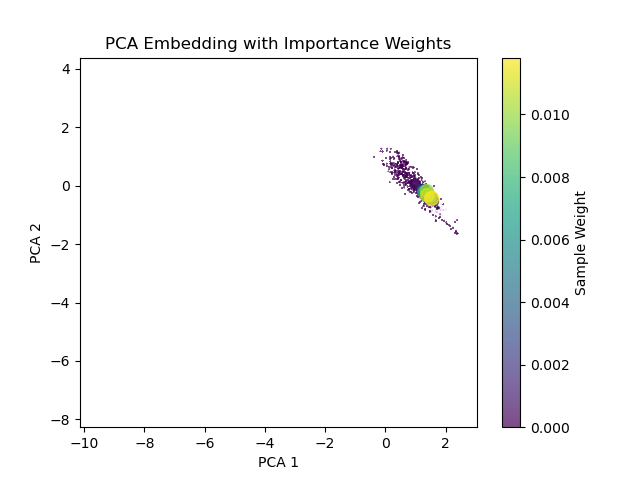

In [ ]:

fig = plt.figure()

for i,
fig.add_subplot(131)
sizes_2d = 100 * (weights / weights.max())
sc2d = plt.scatter(scores_3d[:, 0], scores_3d[:, 1], s=100 * (weights / weights.max()), c=weights, cmap='viridis', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(sc2d, label='Sample Weight')
plt.title('PCA Embedding with Importance Weights')
plt.show()

In [24]:
from sklearn.manifold import TSNE, Isomap

results.samples.shape

X_emb = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(results.samples)


In [33]:
w = results.importance_weights()
w.shape

(4736,)

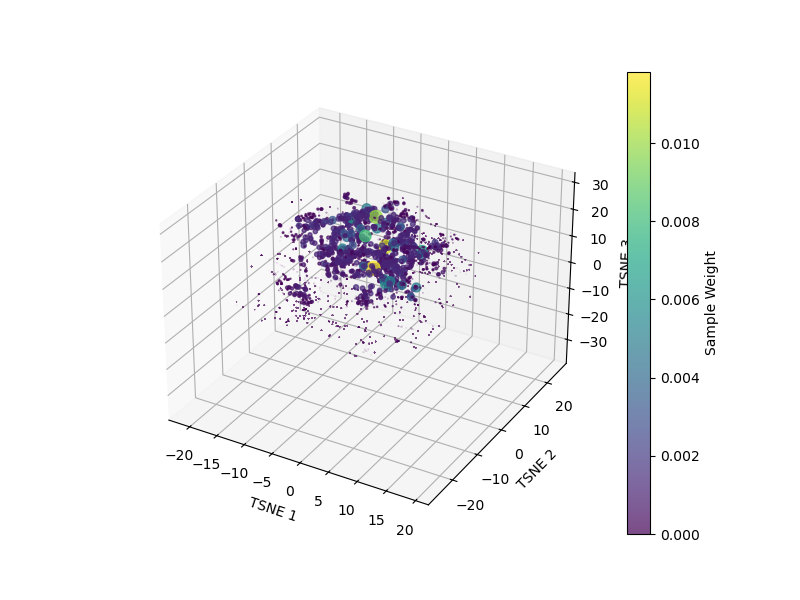

In [34]:
%matplotlib ipympl

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')


# Normalize weights for point sizes
weights = results.importance_weights()
sizes = 100 * (weights / weights.max())

sc = ax.scatter(X_emb[:, 0], X_emb[:, 1], X_emb[:, 2], s=sizes, c=weights, cmap='viridis', alpha=0.7)
ax.set_xlabel('TSNE 1')
ax.set_ylabel('TSNE 2')
ax.set_zlabel('TSNE 3')
fig.colorbar(sc, ax=ax, label='Sample Weight')
plt.show()

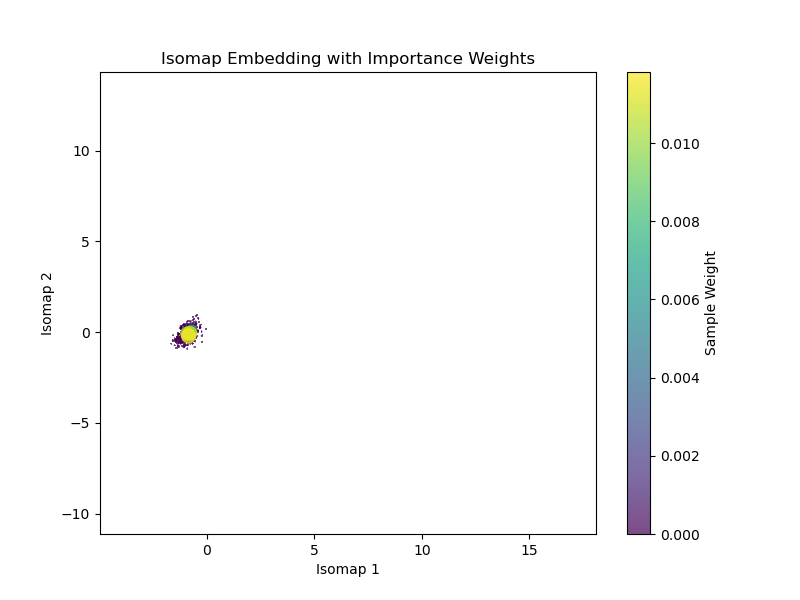

In [ ]:
X_trans = Isomap(n_neighbors=10,n_components=2).fit_transform(results.samples)

plt.figure(figsize=(8, 6))


In [ ]:
sizes_2d = 100 * (weights / weights.max())
sc2d = plt.scatter(X_trans[:, 0], X_trans[:, 1], s=sizes_2d, c=weights, cmap='viridis', alpha=0.7)
plt.xlabel('Isomap 1')
plt.ylabel('Isomap 2')
plt.colorbar(sc2d, label='Sample Weight')
plt.title('Isomap Embedding with Importance Weights')
plt.show()

(4736, 3)

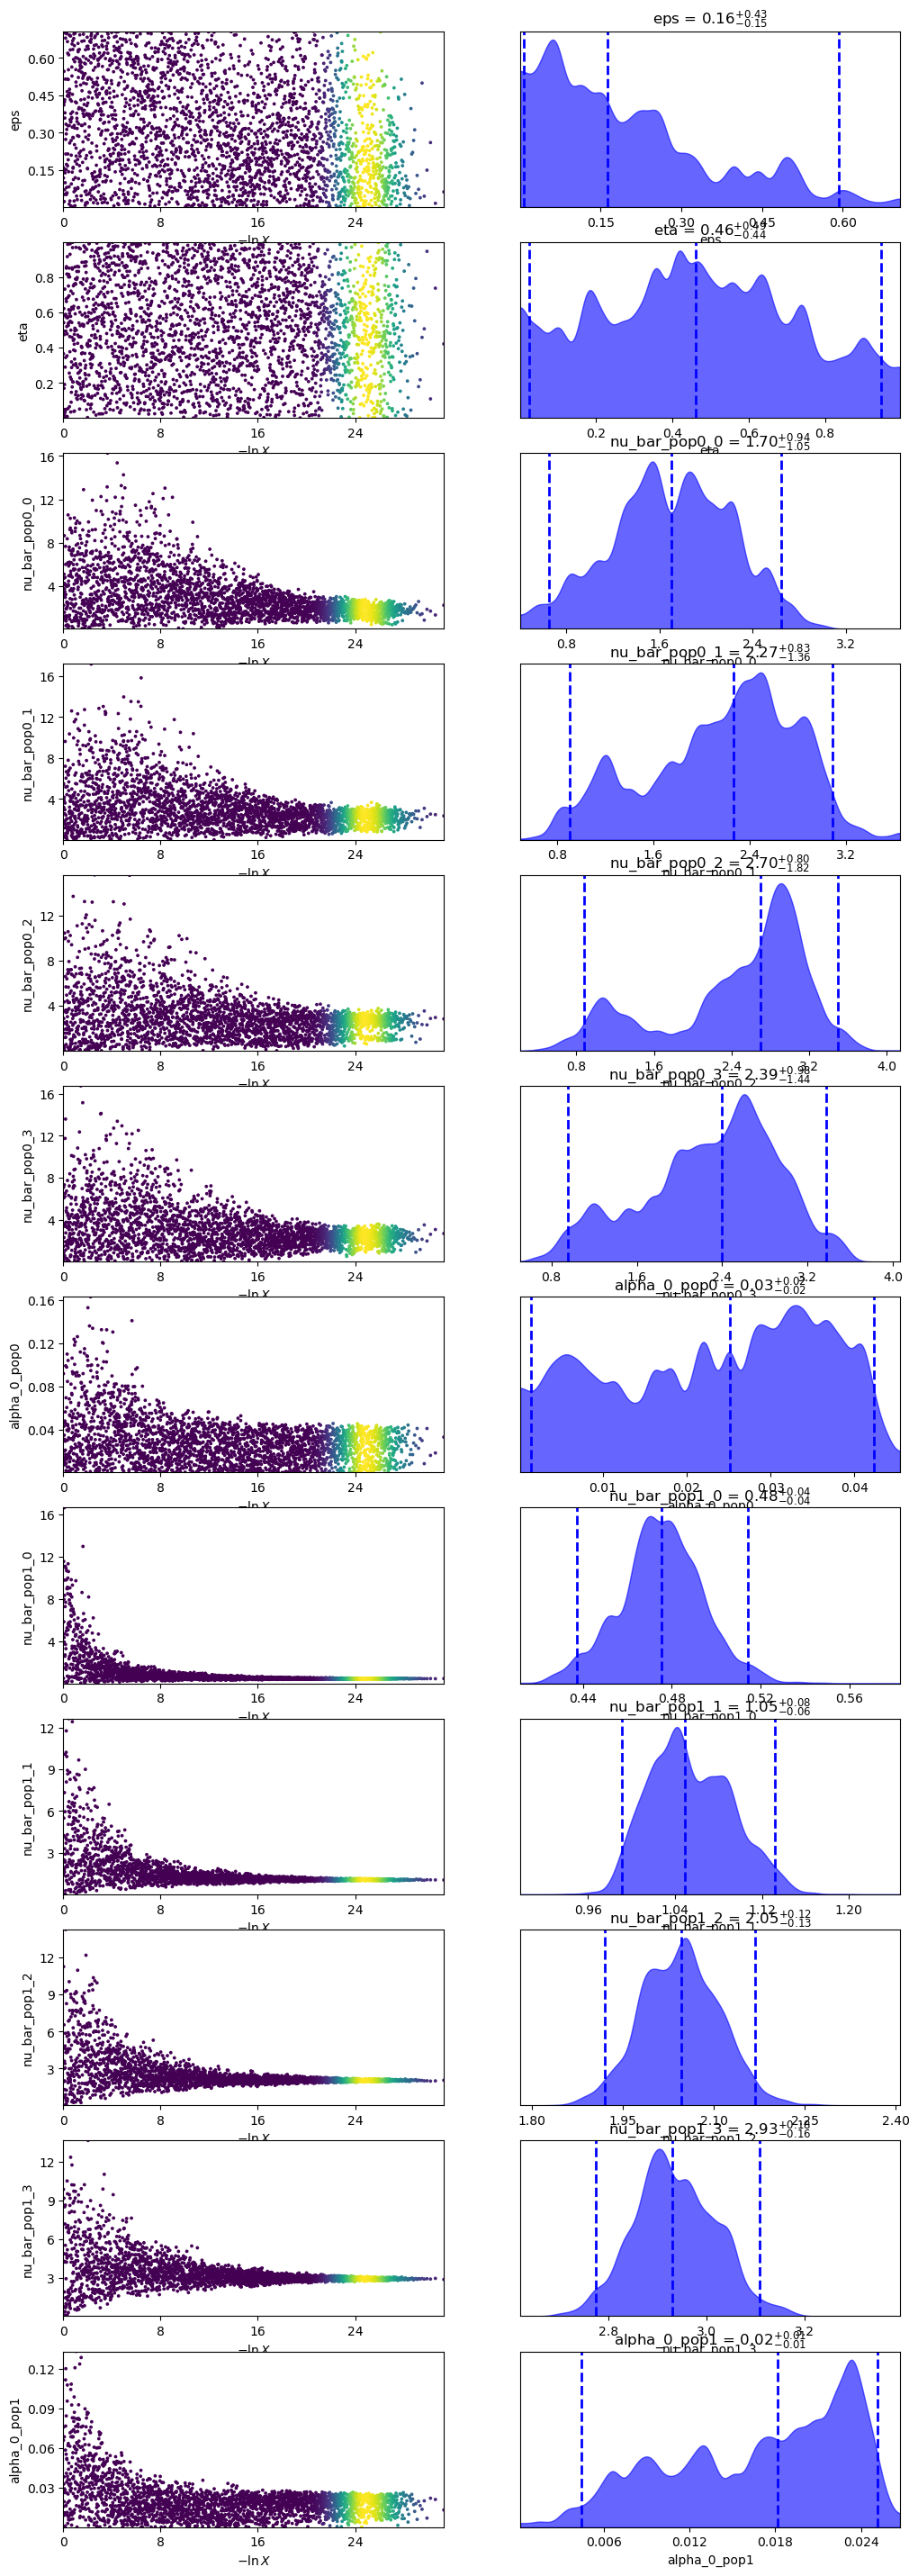

In [34]:
from dynesty import utils as dyfunc, plotting as dyplot

truths = build_truths(ground_truth_params, conditions={"nu_bar_pop1": [0.5,1.,2.,3.]})
# print(truths)
# print(BM.parameter_names)
# truth_list = [truths[key] for key in BM.parameter_names if not key.startswith("tau")]
# print(truth_list)
dyplot.traceplot(
    sampler.results,
    labels=BM.parameter_names_all,
    # truths=truth_list,
    truth_color="black",
    show_titles=True,
    trace_cmap="viridis",
)
plt.show(block=False)

In [11]:
from inference.NestedSamplingMethods import get_mean_from_sampler
mean = get_mean_from_sampler(results, BM.parameter_names_all,mode="dynesty")
mean

{'eps': np.float64(0.20485022367971695),
 'eta': np.float64(0.468043101641952),
 'nu_bar_pop0_0': np.float64(1.698095566981559),
 'nu_bar_pop0_1': np.float64(2.1640881143331634),
 'nu_bar_pop0_2': np.float64(2.454271768377212),
 'nu_bar_pop0_3': np.float64(2.289102953560887),
 'alpha_0_pop0': np.float64(0.023630680654315655),
 'nu_bar_pop1_0': np.float64(0.47515554060430965),
 'nu_bar_pop1_1': np.float64(1.0541274766847843),
 'nu_bar_pop1_2': np.float64(2.044749802733462),
 'nu_bar_pop1_3': np.float64(2.936296174402724),
 'alpha_0_pop1': np.float64(0.016836097297743803)}

In [24]:
conditions = [0.5,1.,2.,4.]
# conditions = [0.5,1.]

gtp = copy.deepcopy(ground_truth_params)
truths = build_truths(gtp, conditions={"nu_bar_pop1": conditions})

N = 1000; T = 120
event_counts = np.zeros((len(conditions),2,N))
for i, nu in enumerate(conditions):
    gtp["distr"][1]["nu_bar"] = nu
    SD,net = create_data_from_params(gtp,N=N,T=T)
    event_counts[i,...] = SD.event_counts

prior = define_biological_prior(event_counts.shape[0])

BM = BayesModel()  # logLevel=logging.WARNING)
BM.prepare_data(event_counts, T=T)
BM.set_priors(prior)
prior_transformation = BM.set_prior_transform(vectorized=False)

# p_in = np.random.uniform(0, 1, size=(BM.n_params,))
# pprint.pprint(p_in)

# p_trafo = prior_transformation(p_in)
# loglikelihood(p_trafo)

In [21]:
loglikelihood = BM.set_logl(
    vectorized=True,
    correct_N=0,
    bias_to_expected_max=0,
    bias_to_mean=0,
    biological=True,
)


p_trafo = []
for key in BM.parameter_names_all:
    p_trafo.append(mean[key])
p_trafo = np.array(p_trafo)

p_trafo[0] = 0.6
p_trafo[1] = 0.4
p_trafo[2] = 2.

n =11
p_trafo = np.tile(p_trafo,(n,1))
p_trafo[:,1] = np.linspace(0,1,n)

Different values of kappa currently not possible - check what needs to be done!


In [22]:
# p_trafo[0] = 0.1
print(p_trafo)
loglikelihood(p_trafo)

[[0.6        0.         2.         2.16408811 0.02363068 0.47515554
  1.05412748 0.0168361 ]
 [0.6        0.1        2.         2.16408811 0.02363068 0.47515554
  1.05412748 0.0168361 ]
 [0.6        0.2        2.         2.16408811 0.02363068 0.47515554
  1.05412748 0.0168361 ]
 [0.6        0.3        2.         2.16408811 0.02363068 0.47515554
  1.05412748 0.0168361 ]
 [0.6        0.4        2.         2.16408811 0.02363068 0.47515554
  1.05412748 0.0168361 ]
 [0.6        0.5        2.         2.16408811 0.02363068 0.47515554
  1.05412748 0.0168361 ]
 [0.6        0.6        2.         2.16408811 0.02363068 0.47515554
  1.05412748 0.0168361 ]
 [0.6        0.7        2.         2.16408811 0.02363068 0.47515554
  1.05412748 0.0168361 ]
 [0.6        0.8        2.         2.16408811 0.02363068 0.47515554
  1.05412748 0.0168361 ]
 [0.6        0.9        2.         2.16408811 0.02363068 0.47515554
  1.05412748 0.0168361 ]
 [0.6        1.         2.         2.16408811 0.02363068 0.47515554
  

array([-1293.23629254, -1293.21709831, -1293.16012535, -1293.06639196,
       -1292.93536556, -1292.76296261, -1292.54061405, -1292.25609412,
       -1291.89651532, -1291.45415402, -1290.93694556])

{'eps': 0.5, 'eta': 0.7, 'nu_bar_pop0': 3.0, 'alpha_0_pop0': 0.01, 'tau_I_s0_pop0': 0.005, 'nu_bar_pop1': [1.0, 2.0], 'alpha_0_pop1': 0.03, 'tau_I_s0_pop1': 0.001}


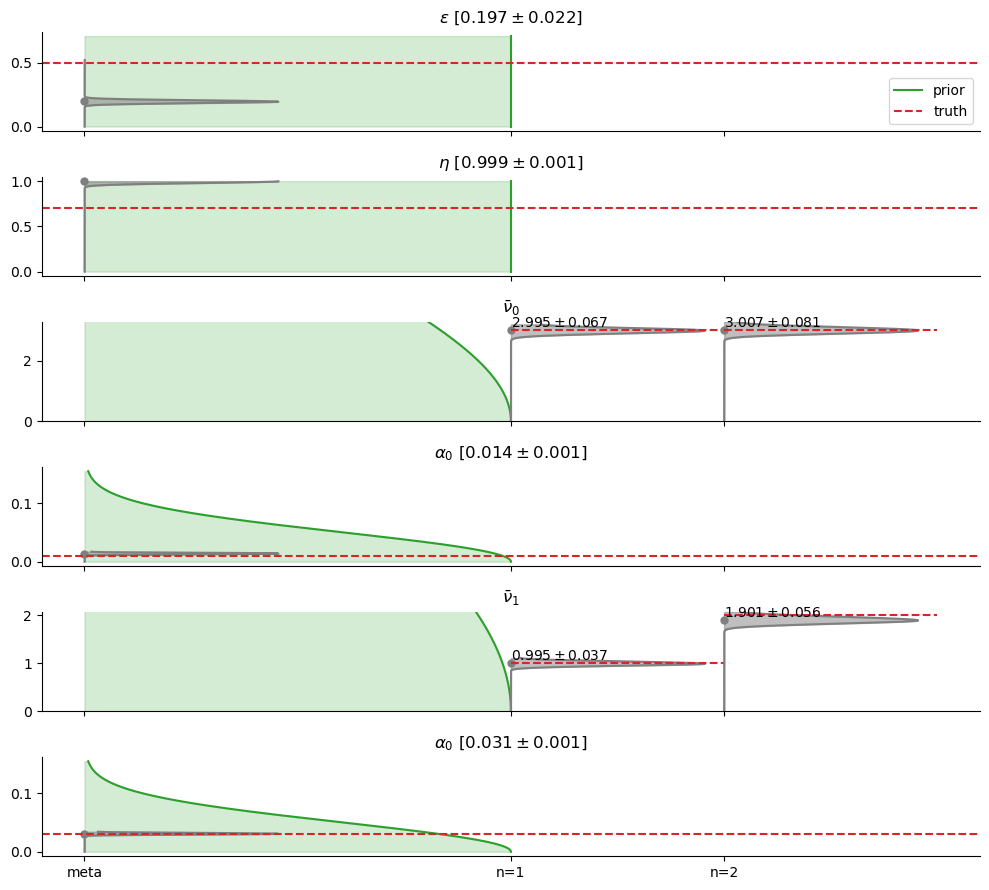

In [42]:
truths = build_truths(ground_truth_params, conditions={"nu_bar_pop1": [1.,2.]})
print(truths)
plot_results(BM,results, mode="dynesty",truths=truths)

self.n_pop=2


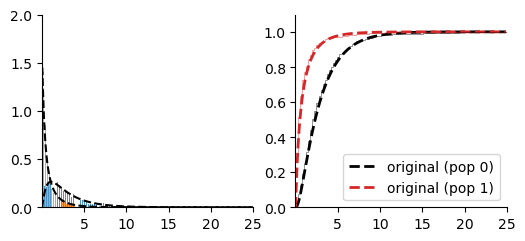

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


1534it [00:10, 140.07it/s, +100 | bound: 29 | nc: 1 | ncall: 80315 | eff(%):  2.037 | loglstar:   -inf < -2068.049 <    inf | logz: -2083.694 +/-  0.375 | dlogz:  0.013 >  1.000]


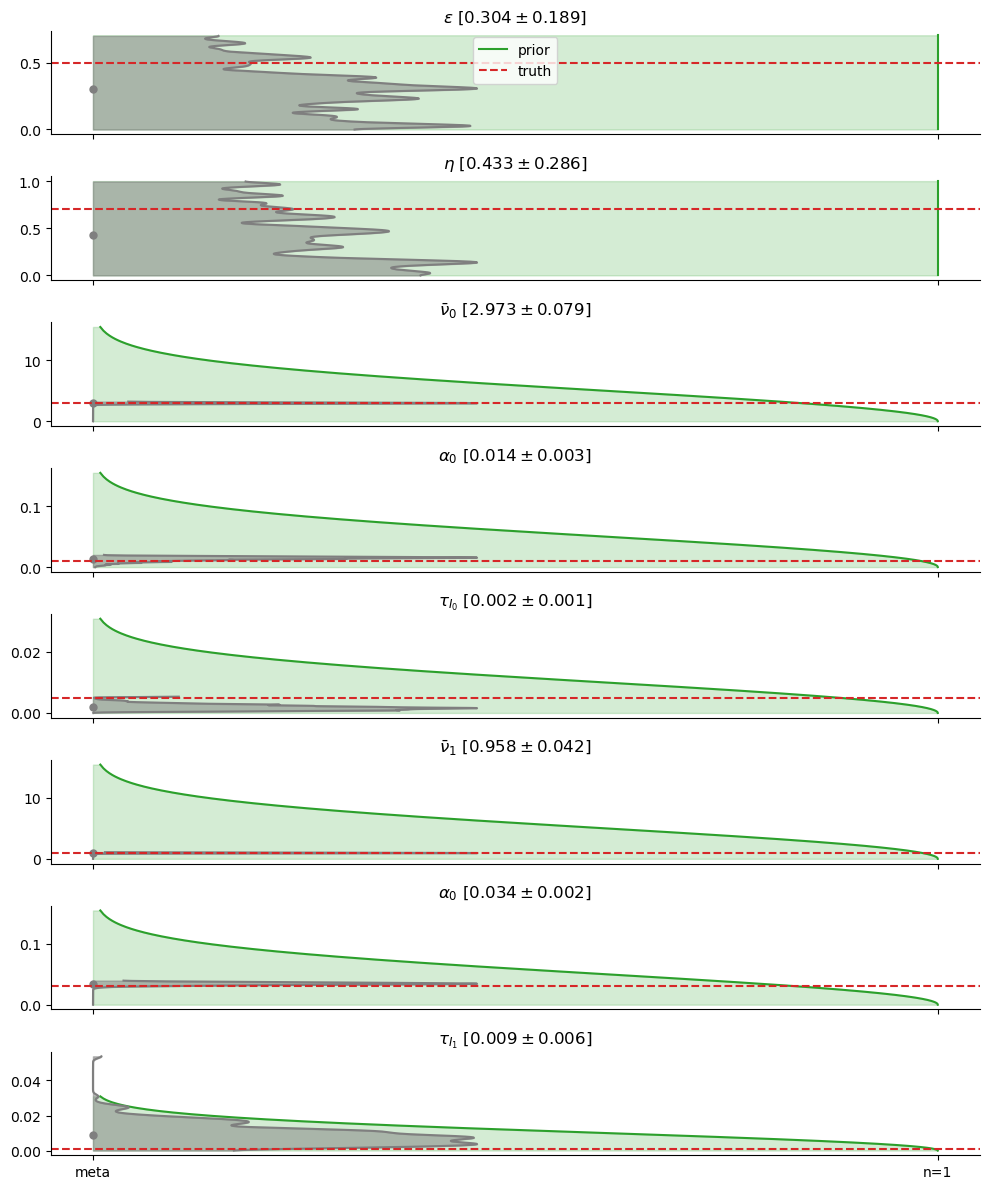

In [ ]:
ground_truth_params = {
    "eps": 0.5,
    "eta": 0.7,
    "distr": [
        {
            "nu_bar": 3., 
            "alpha_0": 0.01, 
            "J0": -1.,
            "synapses": [
                {"tau_I": 0.005}
            ],
        },
        {
            "nu_bar": 1., 
            "alpha_0": 0.03, 
            "J0": 1.,
            "synapses": [
                {"tau_I": 0.001}
            ],
        },
    ],
}
# nu_conditions = [1.]

truths = {}
for key in ["eps","eta"]:
    truths[key] = ground_truth_params[key]
for p,pop in enumerate(ground_truth_params["distr"]):
    for key in ["nu_bar","alpha_0"]:
        truths[f"{key}_pop{p}"] = pop[key]

    for s,syn in enumerate(pop["synapses"]):
        for key in ["tau_I"]:
            truths[f"{key}_s{s}_pop{p}"] = syn[key]
# truths["nu_bar_pop1"] = nu_conditions  # for all conditions

N = 1000; T = 120
SD,net = create_data_from_params(ground_truth_params,N=N,T=T)
event_counts = SD.event_counts

prior = define_biological_prior(event_counts.shape[0])
prior_transformation, loglikelihood, BM = prepare_model(event_counts, prior, T, biological=True)
results, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12)

plot_results(BM,results, mode="dynesty",truths=truths)


self.n_pop=2


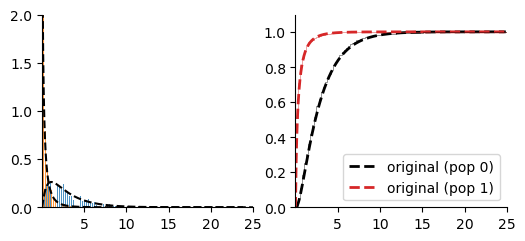

self.n_pop=2


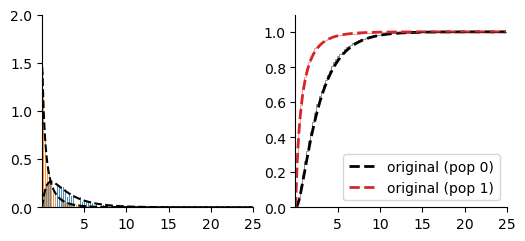

self.n_pop=2


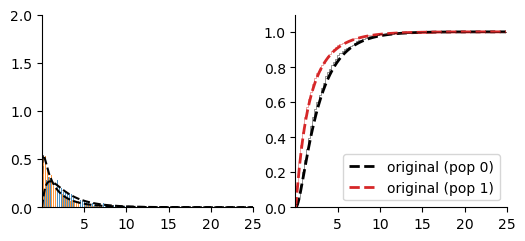

self.n_pop=2


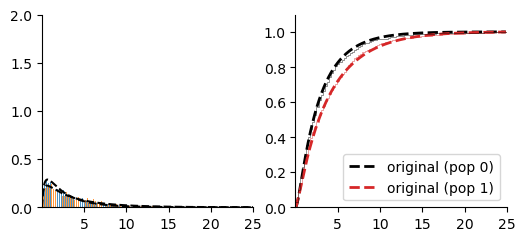

Different values of kappa currently not possible - check what needs to be done!
running nested sampling


3751it [02:14, 27.94it/s, +100 | bound: 83 | nc: 1 | ncall: 283333 | eff(%):  1.360 | loglstar:   -inf < -9177.131 <    inf | logz: -9214.792 +/-  0.629 | dlogz:  0.012 >  1.000]


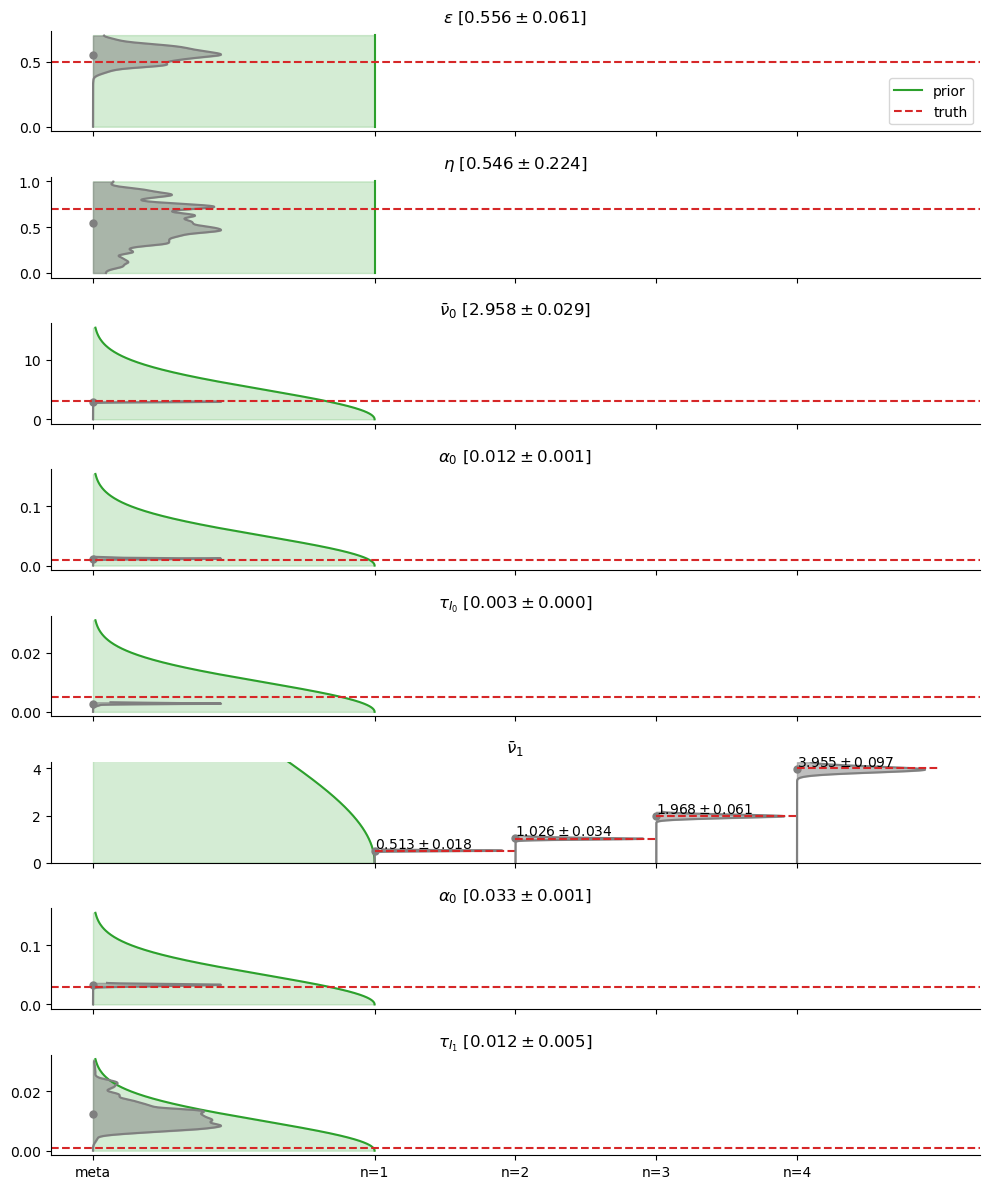

In [18]:
ground_truth_params = {
    "eps": 0.5,
    "eta": 0.7,
    "distr": [
        {
            "nu_bar": 3., 
            "alpha_0": 0.01, 
            "J0": -1.,
            "synapses": [
                {"tau_I": 0.005}
            ],
        },
        {
            "nu_bar": 1., 
            "alpha_0": 0.03, 
            "J0": 1.,
            "synapses": [
                {"tau_I": 0.001}
            ],
        },
    ],
}
nu_conditions = [0.5, 1., 2., 4.]

truths = {}
for key in ["eps","eta"]:
    truths[key] = ground_truth_params[key]
for p,pop in enumerate(ground_truth_params["distr"]):
    for key in ["nu_bar","alpha_0"]:
        truths[f"{key}_pop{p}"] = pop[key]

    for s,syn in enumerate(pop["synapses"]):
        for key in ["tau_I"]:
            truths[f"{key}_s{s}_pop{p}"] = syn[key]
truths["nu_bar_pop1"] = nu_conditions  # for all conditions

N = 1000; T = 120
event_counts = np.zeros((len(nu_conditions),2,N))
for i, nu in enumerate(nu_conditions):
    ground_truth_params["distr"][1]["nu_bar"] = nu
    SD,net = create_data_from_params(ground_truth_params,N=N,T=T)
    event_counts[i,...] = SD.event_counts

prior = define_biological_prior(event_counts.shape[0])
prior_transformation, loglikelihood, BM = prepare_model(event_counts, prior, T, biological=True)
results, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12)

plot_results(BM,results, mode="dynesty",truths=truths)


In [ ]:
"""
why is it not converging nicely?

tau_I -> nu_max direct connection, not adding anything new per condition!
-> +4 params per condition (gamma x2, delta x2)

-> biological parameters a bit more sophisticated: 
- eta, eps, nu_bar_0, nu_bar_1, I_ext_0, I_ext_1 
    - form cluster of 4 independent variables (each nu defined by 4 params)
    - jointly define 5th & 6th if given
    - only eps, eta remain constant across conditions
    -> 2 free params

- additional 2 free parameters alpha_0_0 and alpha_0_1

Thus: 
    4 free parameters per condition 
    + 2 constant (eps, eta) 
    + 2 kinda independent (tau_I_x)

parameters (iff 3 params free above):
    biological vs meta (excl. nu_max) // meta (incl. nu_max) 
    1 cond.: 9 vs 6  // 6
    2 cond.: 14 vs 10 // 12
    3 cond.: 19 vs 14 // 18
    *4 cond.: 24 vs 18 // 24 <- here, eta gets defined!!!
    
parameters (iff 2 params free above):
    biological vs meta (excl. nu_max) // meta (incl. nu_max) 
    1 cond.: 8 vs 6  // 6
    2 cond.: 12 vs 10 // 12 <- here should be sufficient
    3 cond.: 16 vs 14 // 18
    *4 cond.: 20 vs 18 // 24 <- here, eta gets defined!!!

    
In two population case, nu_max doesnt solely depend on tau!!

Remainder indefinite stuff due to bad inferrence of nu_max??
try fixed tau_I?!
"""

In [33]:
n_animals = SD.n_animals
n_pop = SD.n_pop
print(f"{n_animals=}, {n_pop=}")

prior = {}
for p in range(n_pop):
    prior[f"gamma_pop{p}"] = prior_structure(
        norm_ppf,
        mean=prior_structure(halfnorm_ppf, loc=1.0, scale=1.0),
        sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=0.2),
        # halfnorm_ppf, loc=1.0, scale=1.0,
        shape=(n_animals,),
        label=f"$\gamma_{p}$"
    )
    prior[f"delta_pop{p}"] = prior_structure(
        norm_ppf,
        mean=prior_structure(norm_ppf, mean=6.0, sigma=2.),
        sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=0.2),
        # norm_ppf, mean=6.0, sigma=2.,
        shape=(n_animals,),
        label=f"$\delta_{p}$",
    )
    prior[f"nu_max_pop{p}"] = prior_structure(
        # None, value=25.0,
        norm_ppf, mean=30.0, sigma=5.0,
        shape=(1,), 
        label="$\\nu^{max}_{"+str(p)+"}$"
    )

n_animals=3, n_pop=2


# Run inference
* stack event_counts of different conditions in array
* run inference on biological parameters with eps, eta, tau constant (make sure, proper calculation exists, maybe without root finding?!)
* check for convergence for 1, 2, 3 conditions

Different values of kappa currently not possible - check what needs to be done!


running nested sampling


2976it [01:04, 46.29it/s, +100 | bound: 61 | nc: 1 | ncall: 377184 | eff(%):  0.816 | loglstar:   -inf < -6954.247 <    inf | logz: -6984.098 +/-  0.557 | dlogz:  0.010 >  1.000]


Multi-population model
Multi-population model
Single population model
Multi-population model
Multi-population model
Single population model


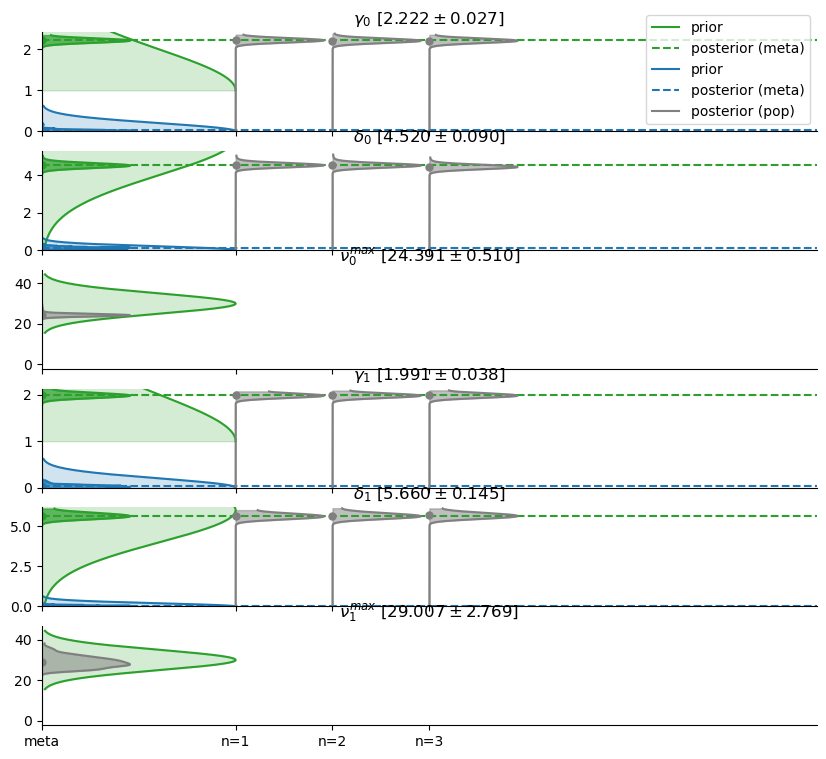

In [41]:
from inference.NestedSamplingMethods import run_sampling, plot_results
results, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12)
plot_results(BM,results, mode="dynesty")

In [42]:
BM = BayesModel()  # logLevel=logging.WARNING)
BM.prepare_data(SD.event_counts, T=ref_values["T"])
BM.set_priors(prior)
prior_transformation = BM.set_prior_transform(vectorized=False)
loglikelihood = BM.set_logl(
    vectorized=False,
    correct_N=0,
    bias_to_expected_max=0,
    bias_to_mean=0,
    biological=True,
)

Different values of kappa currently not possible - check what needs to be done!


running nested sampling


2626it [01:16, 34.15it/s, +100 | bound: 59 | nc: 1 | ncall: 263921 | eff(%):  1.033 | loglstar:   -inf < -6917.585 <    inf | logz: -6944.050 +/-  0.523 | dlogz:  0.011 >  1.000]


Single population model
Single population model
Multi-population model
Single population model
Single population model
Multi-population model
Single population model
Single population model


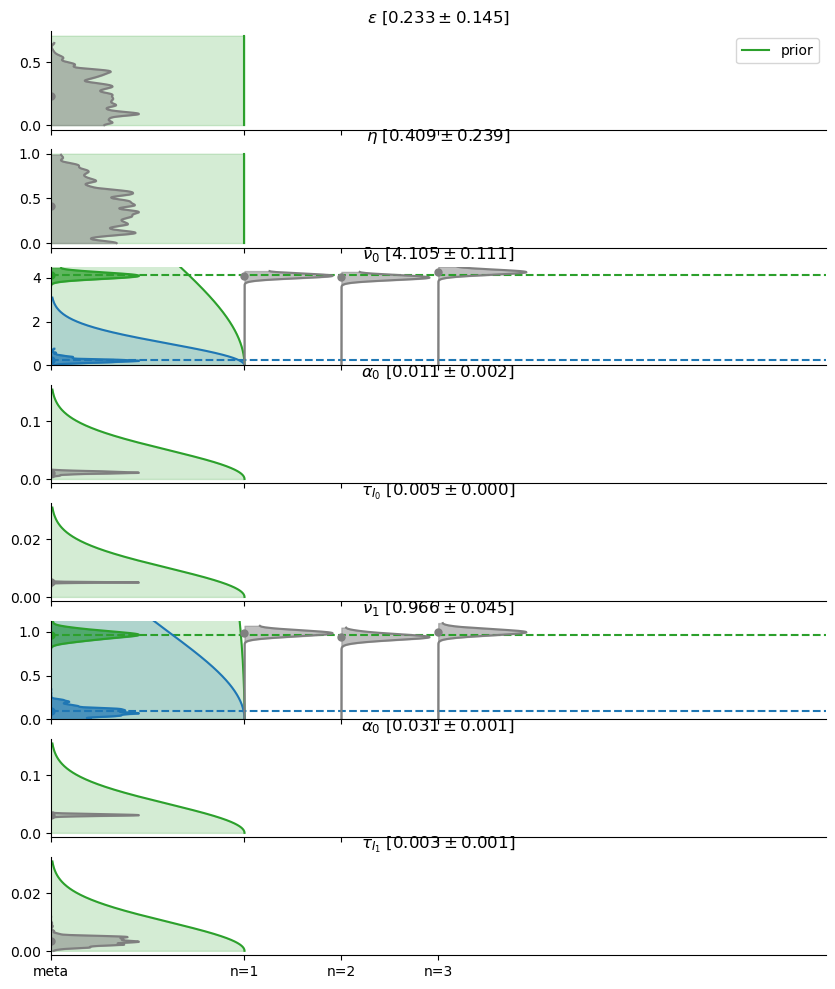

In [43]:
results, sampler = run_sampling(prior_transformation,loglikelihood,BM.parameter_names_all, mode="dynesty",nP=12)
plot_results(BM,results, mode="dynesty")

Single population model
Single population model
Multi-population model
Single population model
Single population model
Multi-population model
Single population model
Single population model


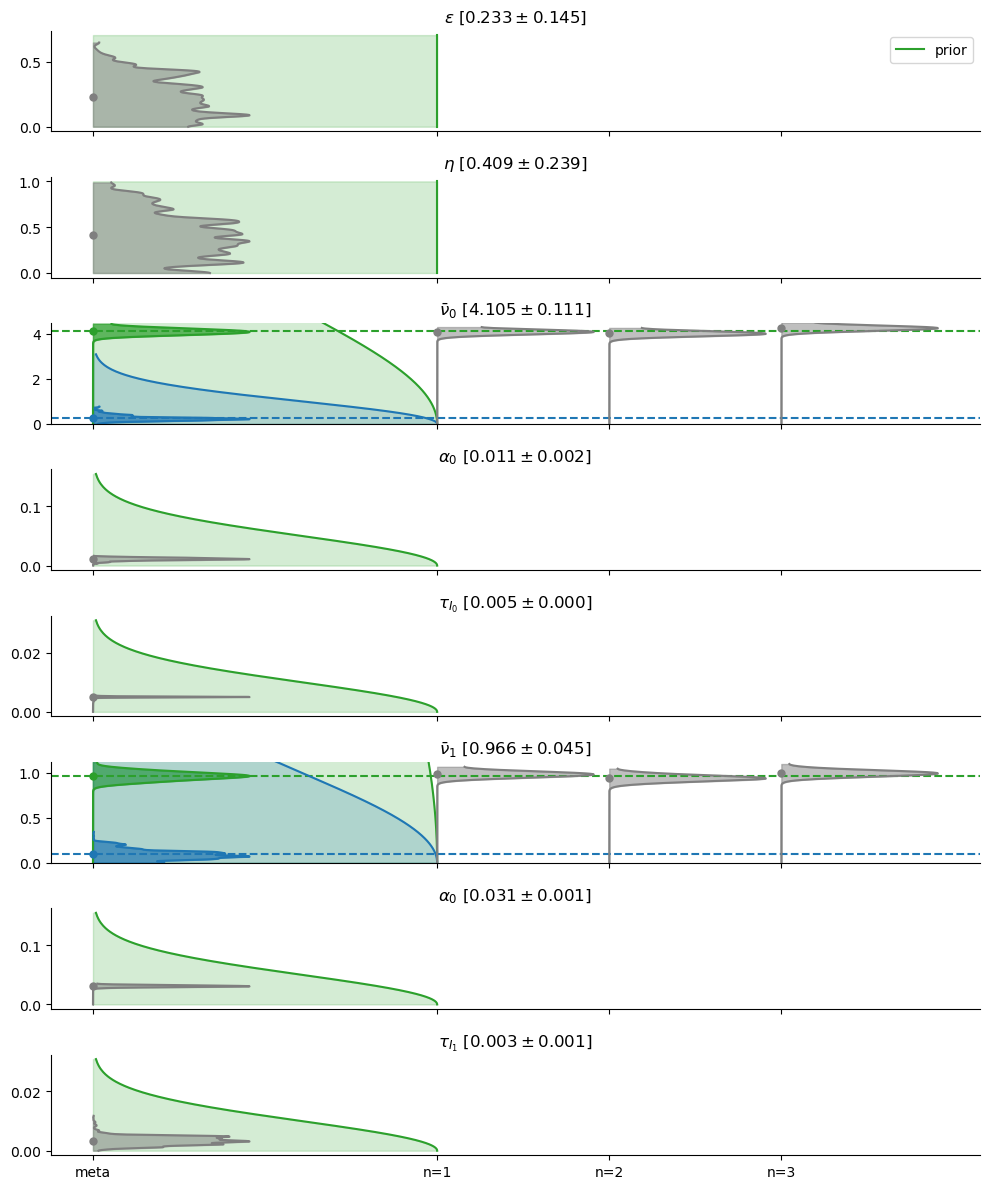

In [47]:
plot_results(BM,results, mode="dynesty")

In [46]:
BM.dimensions

{'shape': (3, 2, 1000),
 'shape_iter': (3,),
 'n': 3,
 'n_iter': 3,
 'names': ['dimension_0_x3', 'dimension_1_x2', 'dimension_2_x1000'],
 'iterator': [(0,), (1,), (2,)],
 'n_pop': 2}

In [39]:
ref_values["distr"]

[DistributionModelParams(gamma=np.float64(2.2190919039959582), delta=np.float64(4.528616280164686), nu_max=np.float64(24.768718291424488), kappa=1.0),
 DistributionModelParams(gamma=np.float64(1.9653734780408834), delta=np.float64(5.535170982193302), nu_max=np.float64(26.191581638761477), kappa=1.0)]

In [13]:
%timeit my_likelihood(p_trafo)

7.49 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
from inference.BayesModel import run_sampling
BM, res, sampler = run_sampling(
    mP.spike_counts.T,
    mP.T,
    prior,
    mode="dynesty",
    n_live=100,
    correct_N=0,
    bias_to_expected_max=0,
    nP=12,
    biological=True
)

running nested sampling


1768it [00:35, 49.29it/s, +100 | bound: 35 | nc: 1 | ncall: 114325 | eff(%):  1.635 | loglstar:   -inf < -825.782 <    inf | logz: -843.476 +/-  0.439 | dlogz:  0.011 >  1.000]


In [89]:
BM.dimensions

{'shape': (6, 50),
 'n': 2,
 'names': ['dimension_0_x6', 'dimension_1_x50'],
 'iterator': [(0,), (1,), (2,), (3,), (4,), (5,)]}

Multi-population model
Single population model
Single population model


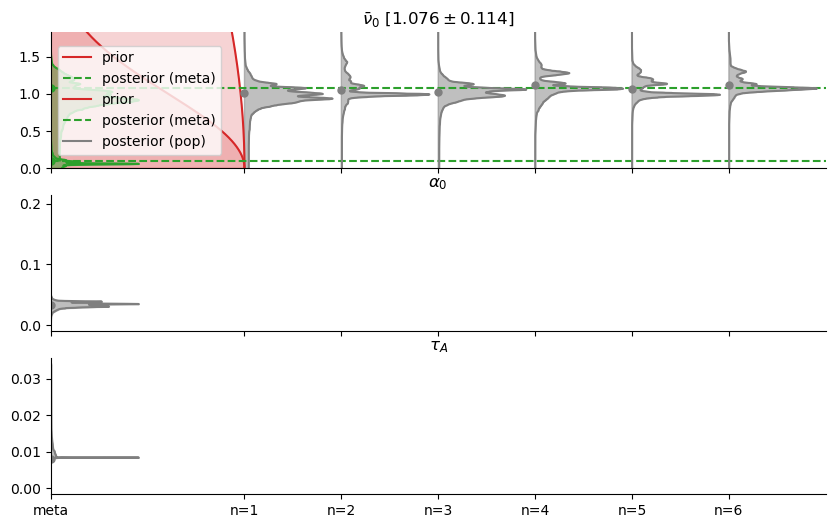

In [90]:
from inference.BayesModel import compare_results, plot_results
# sampler.results
# compare_results(BM, sampler, mP, mode='dynesty')

plot_results(BM,res, mode="dynesty")

In [13]:
from DM_theory.functions import get_gamma, get_delta, get_nu_max


def get_meta(p_bio):
    params = {}
    params["gamma"] = get_gamma(**p_bio)
    params["delta"] = get_delta(**p_bio)
    params["nu_max"] = get_nu_max(**{key:val for key,val in p_bio.items() if key not in ["alpha_0"]})
    return params

values = {
    "distr": [get_meta(p_bio)]
}
# params = get_meta(p_bio)
values

{'distr': [{'gamma': np.float64(2.349963000613782),
   'delta': np.float64(6.287589766003657),
   'nu_max': np.float64(22.507907903927652)}]}

In [52]:
from empirical.create_surrogate_data import SurrogateData, calculate_biological_parameters_from_meta
# ref = {"gamma": 1.5, "delta": 4.5, "nu_max": 25.0}

# calculate_biological_parameters_from_meta(ref_values["distr"])
# calculate_biological_parameters_from_meta([params])
p_bio = {
    "nu_bar": np.nan,
    "alpha_0": 0.02,
    "tau_A": 0.005,
    "tau_N": 0.2,
    "r_N": 0.0
}

nu_vals = [0.5,1.,2.]

SD = SurrogateData(N=1000,T=1200,n_animals=1)
event_counts = np.zeros((len(nu_vals), SD.N))
for i, nu in enumerate(nu_vals):

    p_bio["nu_bar"] = nu

    values = {
        "distr": [get_meta(p_bio)]
    }
    event_counts[i, :] = SD.artificial_data(values, plot=False)

input parameters: gamma=1.8463682139406767, delta=5.695323029991212, nu_max=22.507907903927652, 
inferred parameters: rateWnt=[np.float64(0.49999999999999967)], tau_I=[np.float64(0.005)], alpha_0=[array([[0.01971982]])], 
input parameters: gamma=2.349963000613782, delta=6.287589766003657, nu_max=22.507907903927652, 
inferred parameters: rateWnt=[np.float64(1.0000000000000004)], tau_I=[np.float64(0.005)], alpha_0=[array([[0.01941878]])], 
input parameters: gamma=2.537044422065096, delta=5.910150128836054, nu_max=22.507907903927652, 
inferred parameters: rateWnt=[np.float64(1.9999999999999996)], tau_I=[np.float64(0.005)], alpha_0=[array([[0.01820313]])], 


In [53]:
n_animals = event_counts.shape[0]
prior = {}
prior["nu_bar_pop0"] = prior_structure(
    halfnorm_ppf,
    loc=0.,
    scale=1.,
    # norm_ppf,
    # mean=prior_structure(halfnorm_ppf, loc=0.0, scale=5.0),
    # sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=1.),
    shape=(n_animals,),
    label="$\\bar{\\nu}_0$"
)
prior["alpha_0_pop0"] = prior_structure(
    # halfnorm_ppf,
    # loc=0.0,
    # scale=0.05,
    norm_ppf,
    mean=prior_structure(halfnorm_ppf, loc=0.0, scale=0.05),
    sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=0.005),
    shape=(n_animals,),
    label="$\\alpha_0$"
)


prior["tau_A_pop0"] = prior_structure(
    # halfnorm_ppf,
    # loc=0.0,
    # scale=0.01,
    norm_ppf,
    mean=prior_structure(halfnorm_ppf, loc=0.0,scale=0.01),
    sigma=prior_structure(halfnorm_ppf, loc=0.0, scale=0.001),
    shape=(n_animals,),
    label="$\\tau_A$"
)
prior["tau_N_pop0"] = prior_structure(None, value=0.2)
prior["r_N_pop0"] = prior_structure(None, value=0)

In [54]:
from inference.BayesModel import run_sampling
BM, res, sampler = run_sampling(
    event_counts,
    SD.T,
    prior,
    mode="dynesty",
    n_live=100,
    correct_N=0,
    bias_to_expected_max=0,
    nP=12,
    biological=True
)

running nested sampling


1775it [01:22, 21.63it/s, +100 | bound: 31 | nc: 1 | ncall: 129526 | eff(%):  1.449 | loglstar:   -inf < -6909.032 <    inf | logz: -6926.775 +/-  0.439 | dlogz:  0.011 >  1.000]


Multi-population model
Multi-population model
Multi-population model


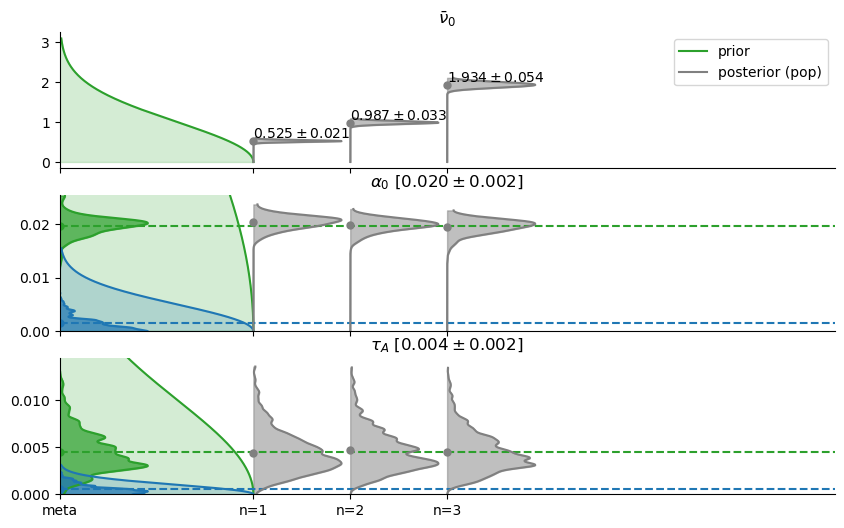

In [108]:
from inference.BayesModel import compare_results, plot_results
plot_results(BM,res, mode="dynesty")

(<Figure size 2860x2860 with 169 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='$x_{2}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$x_{3}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$x_{4}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$x_{5}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$x_{6}$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >, <A

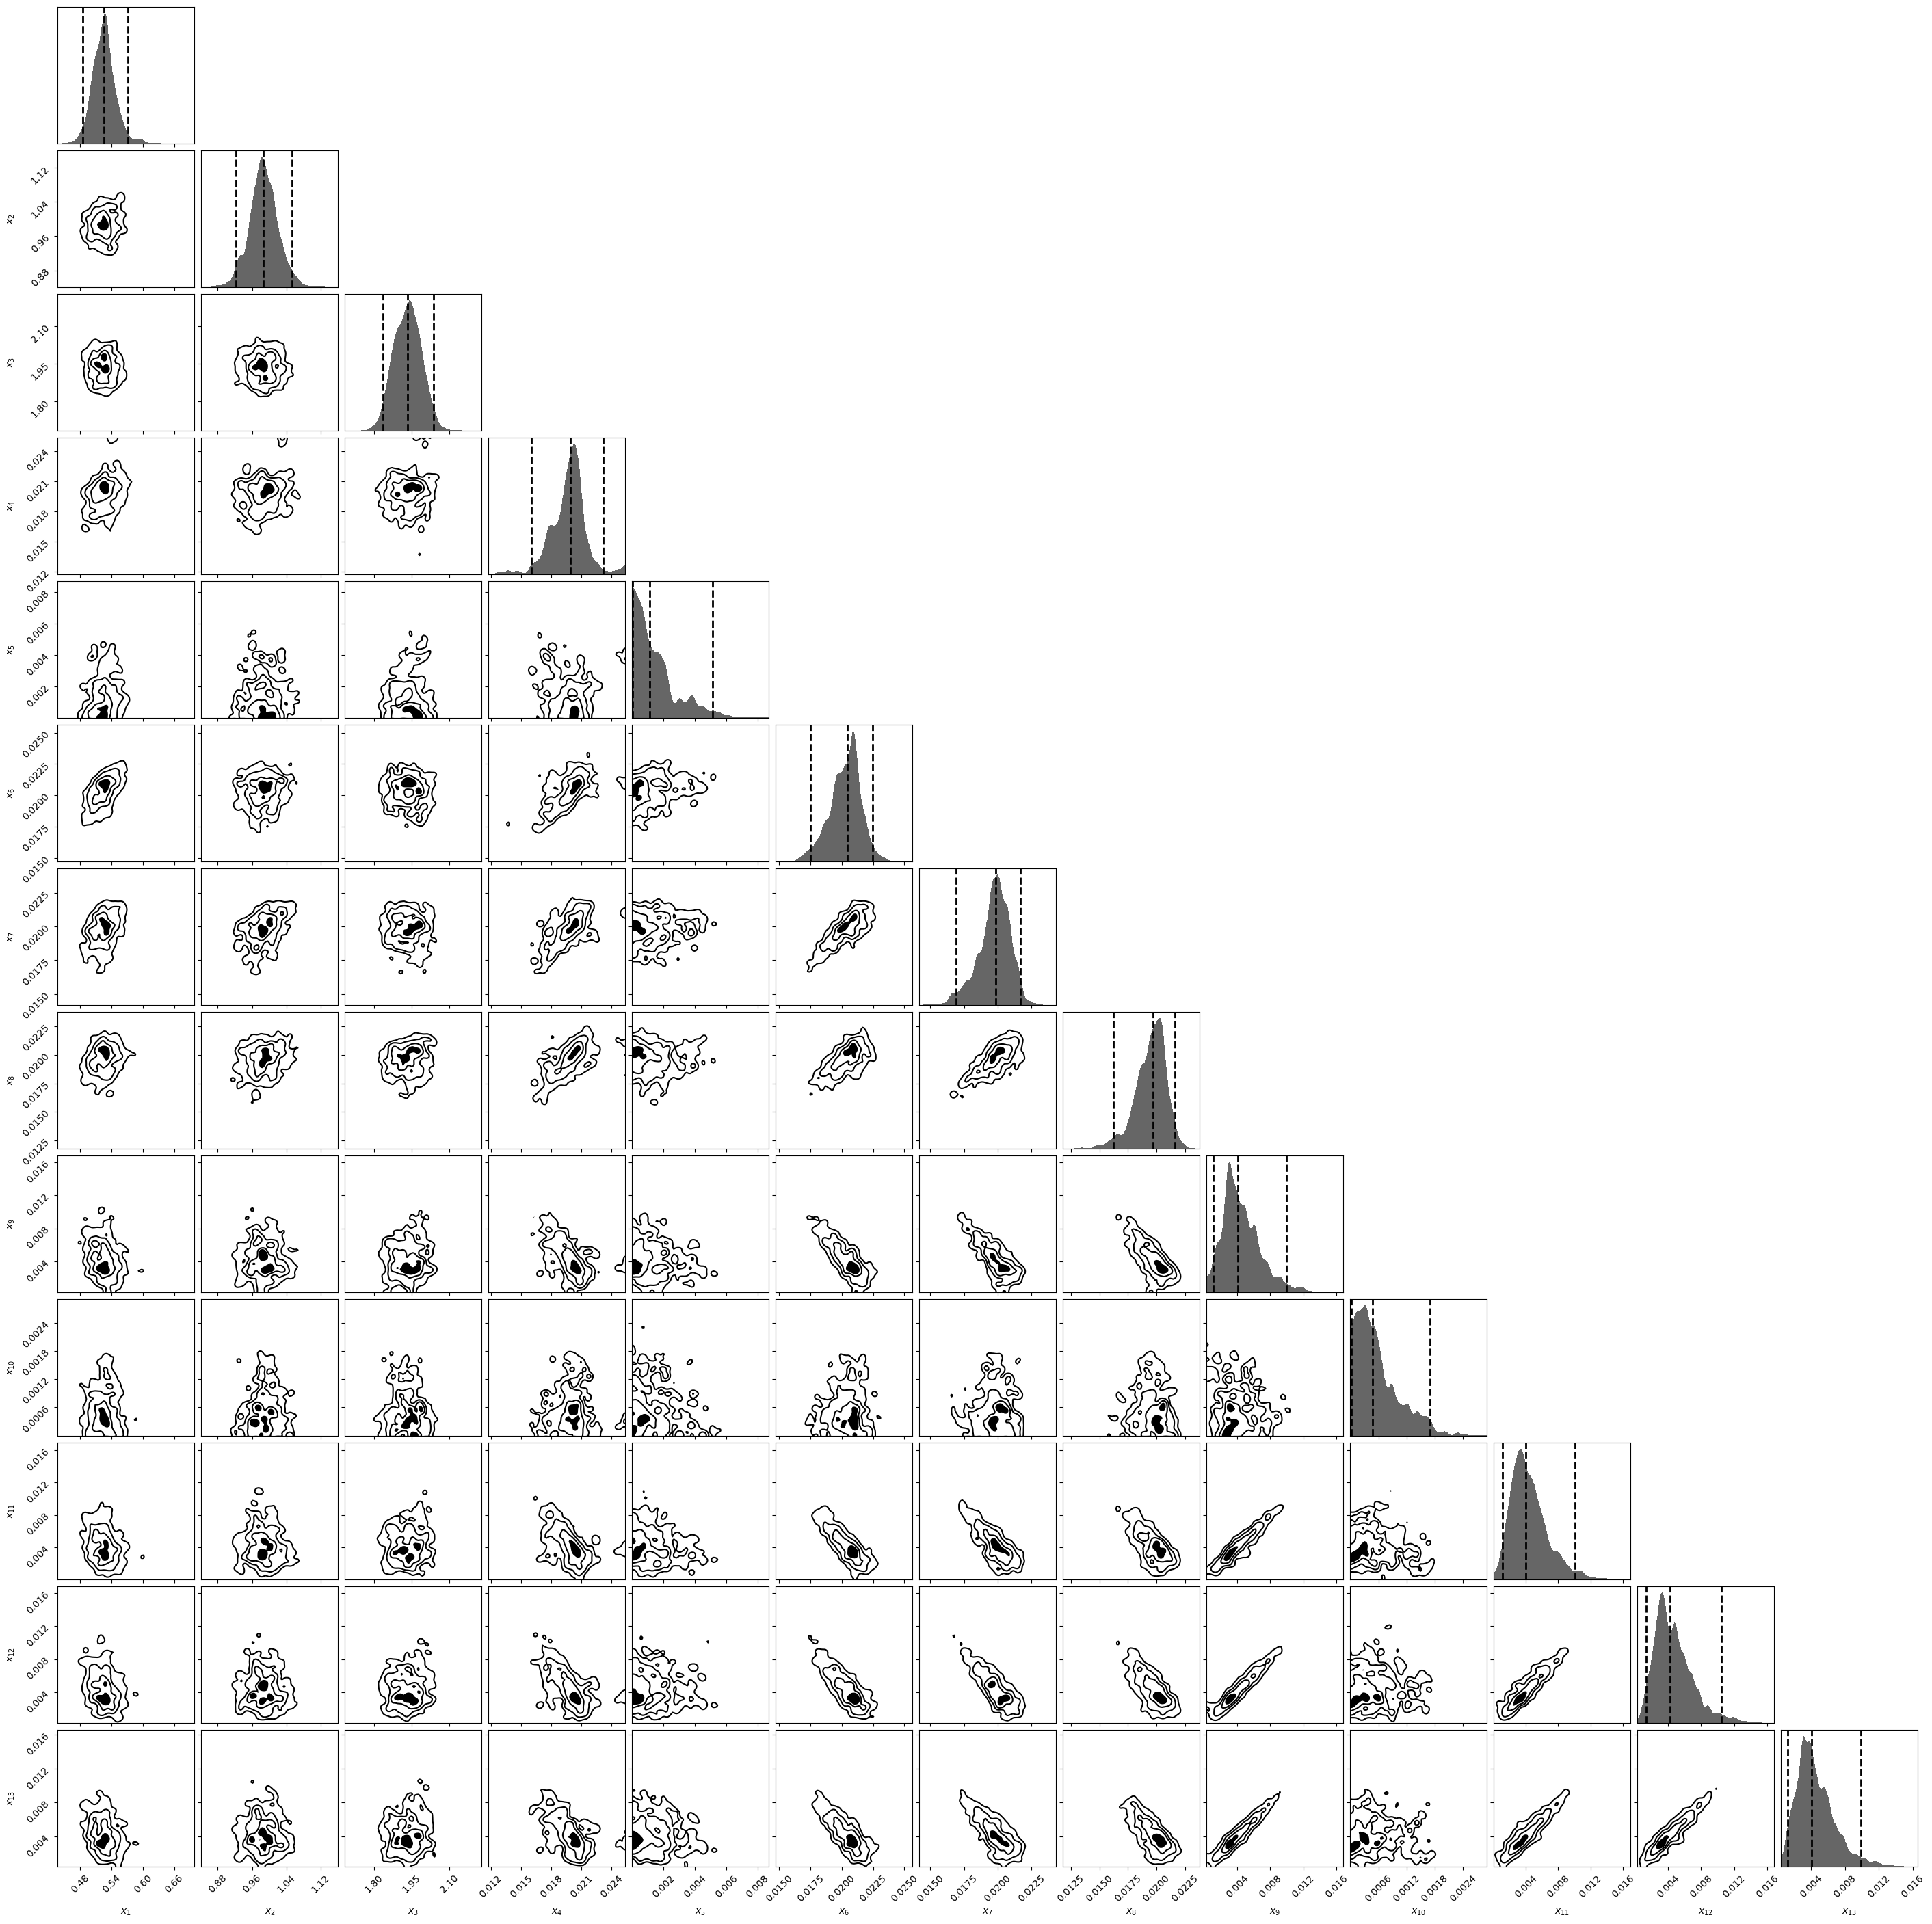

In [62]:
from dynesty import utils as dyfunc, plotting as dyplot

dyplot.cornerplot(sampler.results)